# Act 3: Generate from Data

In this notebook, you'll generate new video content from existing data - creating trailer images and videos automatically from your scene library. In a typical workflow, this means opening editing software for a single clip, extracting frames, calling AI APIs, crafting prompts, exporting the media output, experimenting with prompt tweaks, then writing some for loops in Python scripts to rinse and repeat 100 times for 100 clips.

In Pixeltable, we can express this workflow without any explicit data handling. It is still the same work, same conceptual flow, but you don't have to craft the data operations. Instead, you can focus on the logic and Pixeltable handles the rest.

The techniques you'll learn apply to any workflow that chains transformations and applies them across data:

- Chaining AI models where outputs from one become inputs to the next
- Applying multi-step pipelines to entire datasets without loops
- Testing transformations on single items before processing all data
- Building workflows that incrementally process new data as it arrives

## In this notebook
1. **Extract Frames** - Pull representative frames from each video scene
2. **Generate Creative Prompts** - Use multimodal AI to create trailer descriptions from frames and transcripts
3. **Create Visual Content** - Generate images and videos from AI prompts
4. **Apply Across All Scenes** - Run the workflow on your entire scene library automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models and Pixeltable UDFs used in this notebook:**

| Google Model | Pixeltable UDF | Purpose |
|--------------|----------------|----------|
| `gemini-2.0-flash-exp` | `pxtf.gemini.generate_content()` | Generate text descriptions from images |
| `imagen-4.0-generate-001` | `pxtf.gemini.generate_images()` | Generate images from text prompts |
| `veo-3.1-generate-preview` | `pxtf.gemini.generate_videos()` | Generate videos from images and text |

In [3]:
import pixeltable as pxt
import pixeltable.functions as pxtf

As we've been doing, we'll take a look at the tables we can "get":

In [8]:
pxt.list_tables()

['scene_view', 'primetime_vids', 'sentences']

We'll be working with our `scene_view` table. 

In [9]:
scene_view = pxt.get_table('scene_view')

You can uncomment the code below if you have already gone through this notebook and want to start fresh with the state of `scene_view` before adding any generative AI model inputs or outputs.

In [ ]:
#scene_view.drop_column(scene_view.trailer_image)
#scene_view.drop_column(scene_view.trailer_prompt)
#scene_view.drop_column(scene_view.beginning_frame)

We can also check out the history of our table, to revisit where we've been!

In [11]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,17,2026-01-27 03:19:54.814359+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
1,16,2026-01-27 03:19:54.805257+00:00,None,schema,0,18,0,0,Deleted: trailer_prompt
2,15,2026-01-27 03:19:54.795392+00:00,None,schema,0,18,0,0,Deleted: trailer_image
3,14,2026-01-27 02:11:50.513707+00:00,None,schema,0,18,0,0,Added: trailer_image
4,13,2026-01-27 01:58:21.501940+00:00,None,schema,0,18,0,0,Added: trailer_prompt
5,12,2026-01-27 01:56:48.072202+00:00,None,schema,0,18,0,0,Added: beginning_frame
6,11,2026-01-27 01:51:52.219388+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
7,10,2026-01-27 01:17:23.320129+00:00,None,schema,0,18,0,0,Added: beginning_frame
8,9,2026-01-27 01:17:23.313928+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
9,8,2026-01-26 23:38:22.421115+00:00,None,schema,0,18,0,0,Added: beginning_frame


In addition to seeing table history, you can do time travel, rollback to a previous version, and revert changes. See this page in our docs for more: https://docs.pixeltable.com/platform/version-control

As a reminder, here is our view schema:

In [12]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

You already have `scene_view` from Act 2 with video segments for each scene. Now you'll add a computed column to extract a frame from each segment.

Computed columns work on views the same way they work on tables - they're automatically applied to every row. Here, `extract_frame()` is a Pixeltable UDF that pulls a single frame at a specific timestamp from each video segment. If anything changed in our base table, `primetime_vids`, any changes in scenes and frames would automatically be reflected in this view. That means adding or removing rows from that base table will trigger a parallel action in the view table.

This frame extraction happens once and is stored persistently. All <todo update number 10> scenes are processed automatically. If you add a new row to the base table, only those new scenes and frames would be processed because Pixeltable does incremental updates.

In [13]:
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=0.5),
    if_exists='replace'
)

Added 18 column values with 0 errors in 0.88 s (20.51 rows/s)


18 rows updated.

Here is a sneak peek at the frames:

pos,beginning_frame
5,
6,
7,

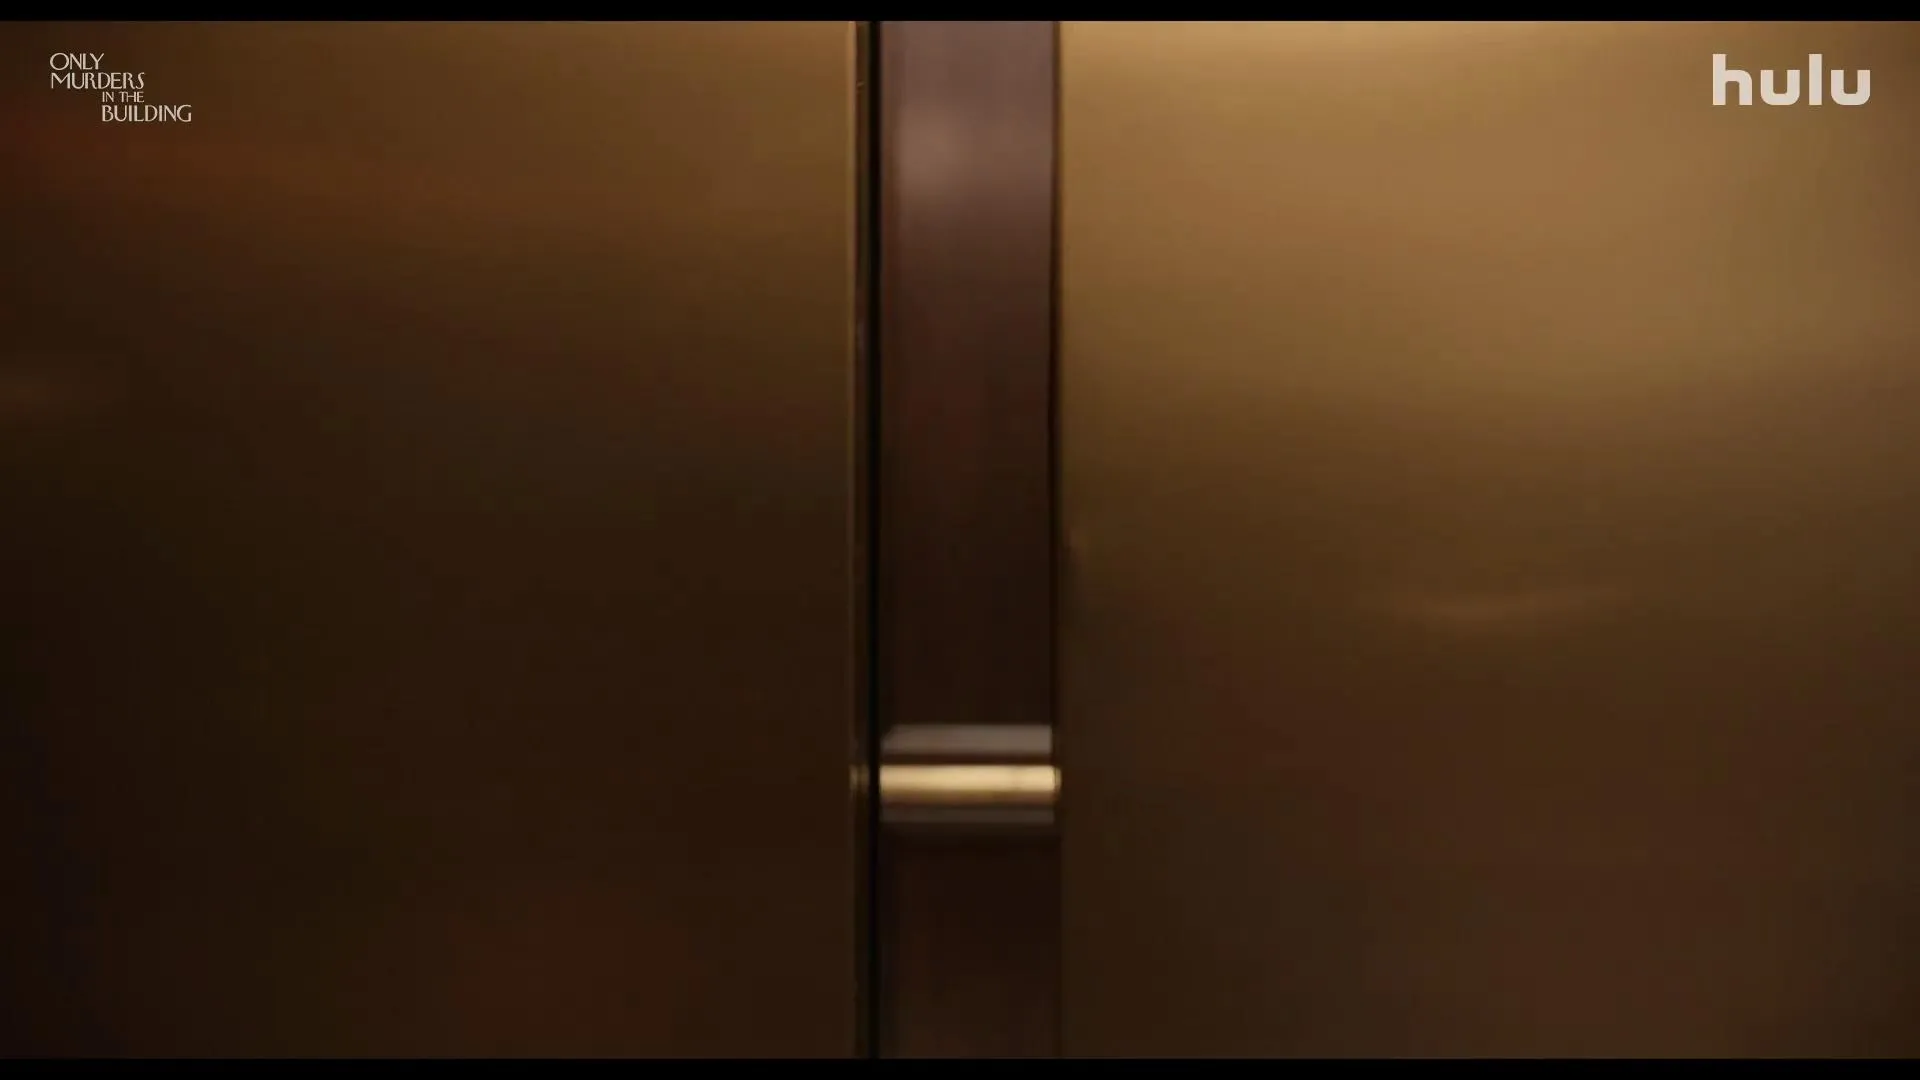
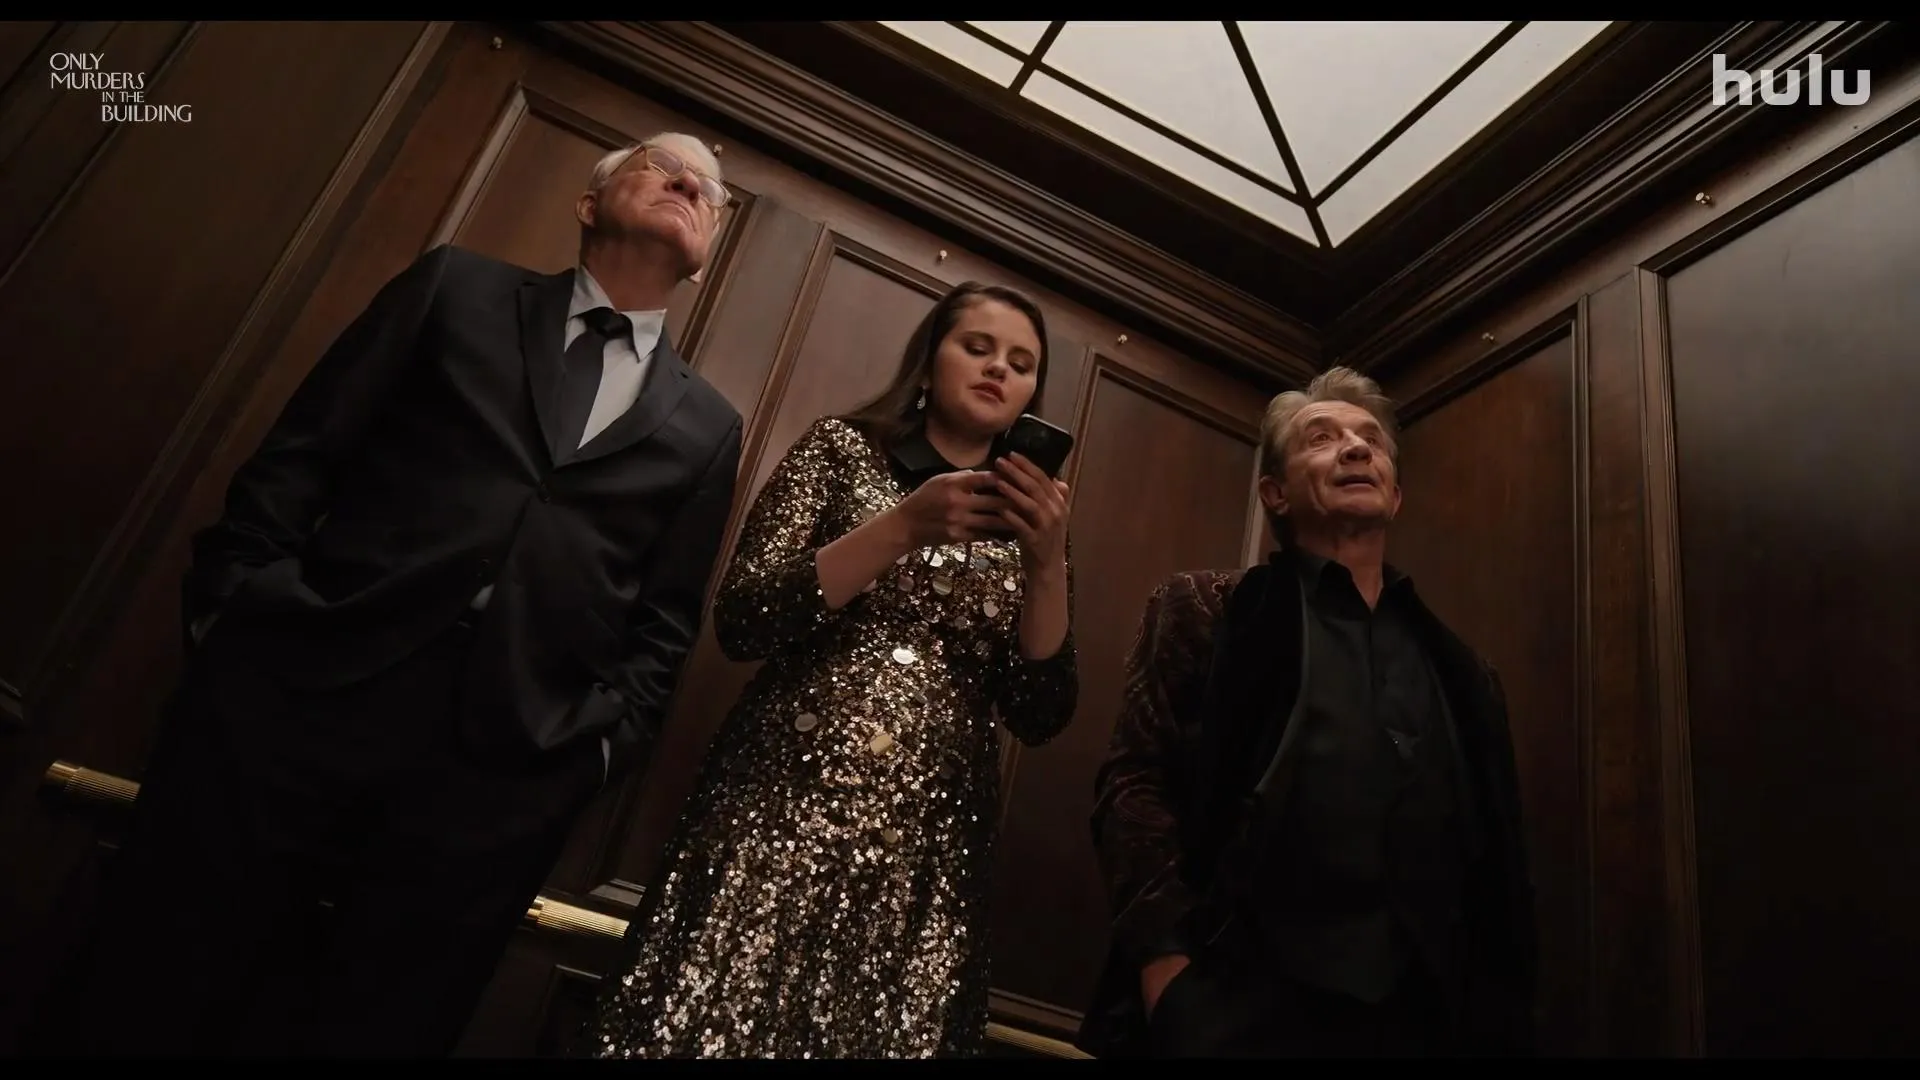
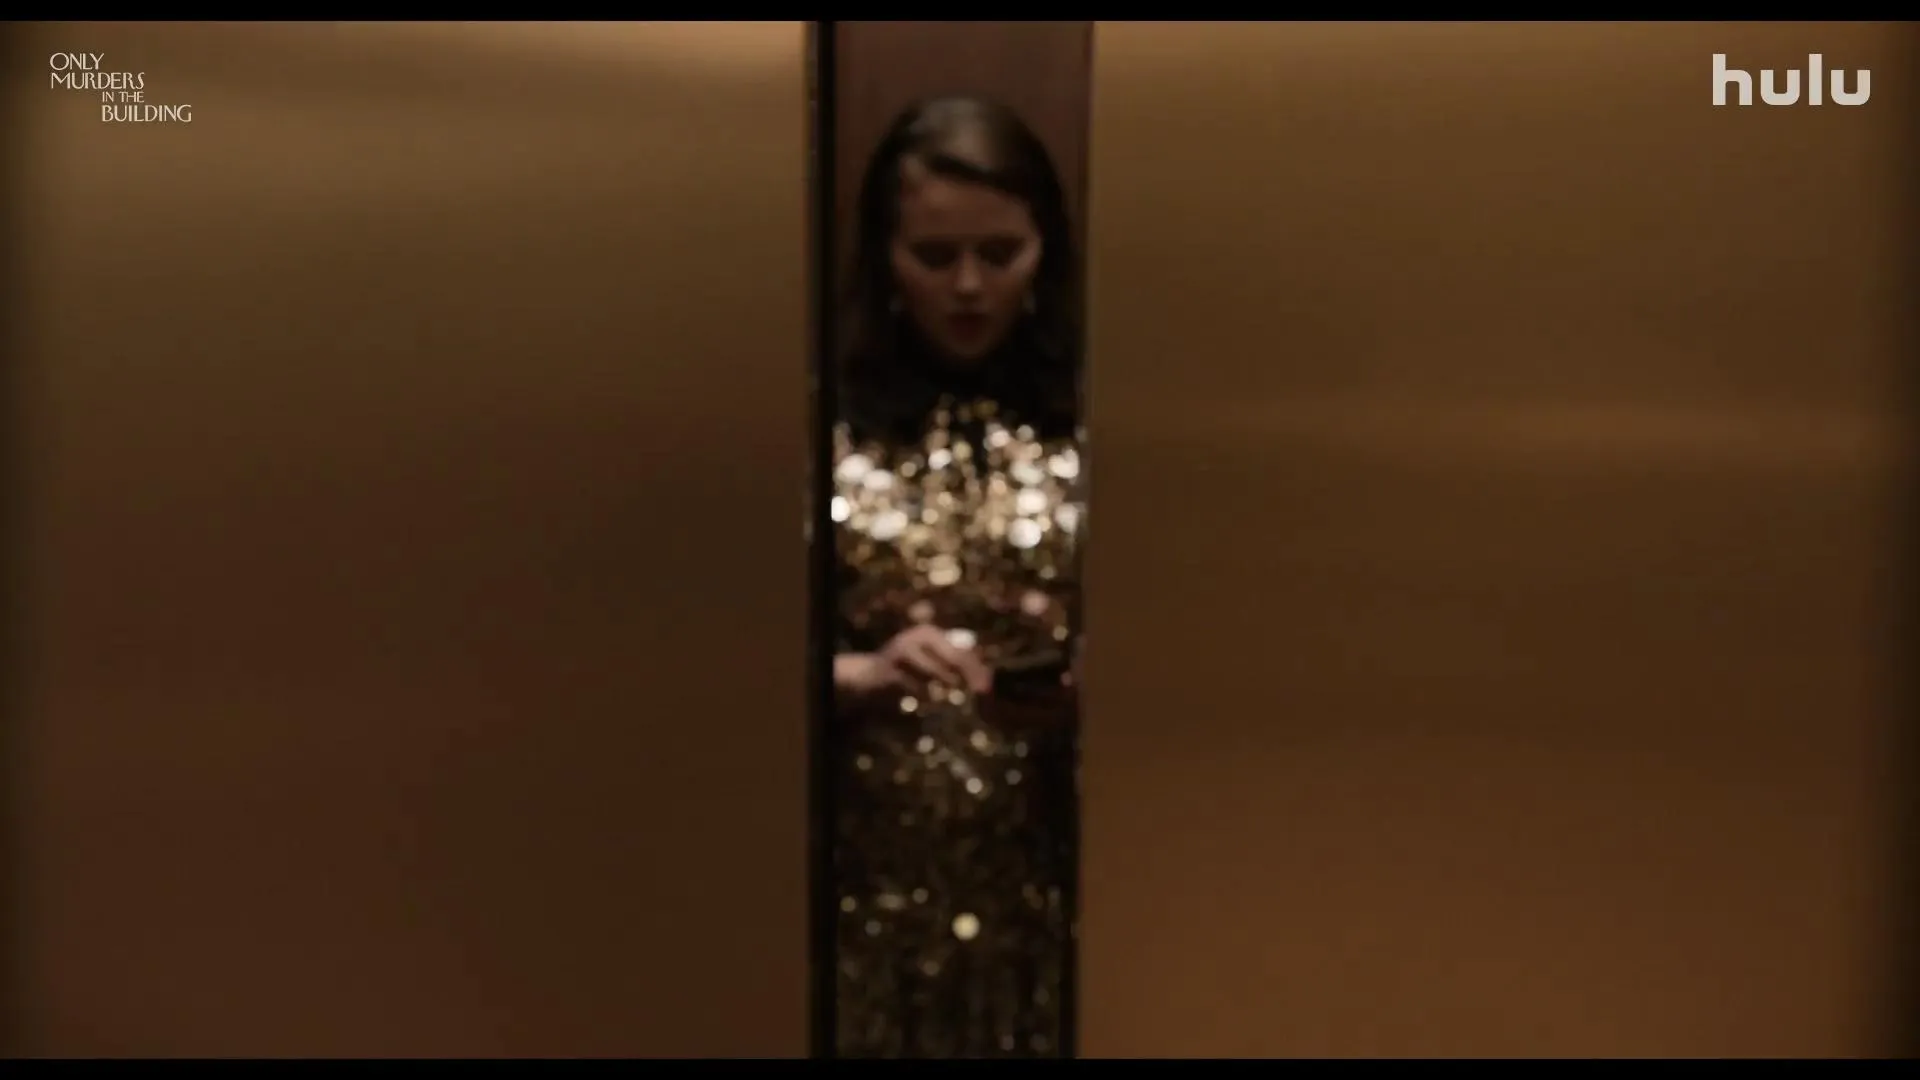

In [14]:
scene_view.select(scene_view.pos, scene_view.beginning_frame).tail(3)

## 02 - Generate AI Prompts

Now let's use AI to generate creative trailer prompts for each scene.

We'll define a **Pixeltable expression** - a reusable transformation that references table columns. Expressions are powerful because:
- They can be used and reused in queries (`.select()`) or as computed columns (`.add_computed_column()`)
- When added as computed columns, they're automatically applied to new rows in a table
- They can reference multiple columns of any data type in a single operation

Here we'll create a **multimodal expression** that combines multiple data types in one API call:
- **Image data**: `scene_view.beginning_frame` (the extracted frame)
- **Text data**: `scene_view.transcript_text` (what's being said)
- **Context data**: `scene_view.title` and `scene_view.promo_text` (movie information)

All of these inputs are bundled together and sent to Gemini's `gemini-2.0-flash-exp` model in a single operation - combining vision and language understanding.

We'll use a careful workflow in this section: define the expression once, test it on one row with `.select().where()`, then apply it to all rows with `.add_computed_column()`. This workflow helps you iterate quickly before committing to expensive operations across your entire dataset.

Pixeltable provides built-in UDFs for Google's Gemini API, wrapping the API calls in functions that work seamlessly with table columns. Here is the composed prompt, written as a Pixeltable expression that uses the built-in Gemini UDF for `generate_content()`. 

In [15]:
trailer_prompt_expr = pxtf.gemini.generate_content(
    contents=[
        'You are creating trailer prompts for an image generator. ' +
        'Movie: "' + scene_view.title + '". ' +
        'Description: ' + scene_view.promo_text + '. ' +
        'This frame is from one scene. ' +
        'What is said: ' + scene_view.transcript_text + '. ' +
        'Write ONLY a 1-2 sentence cinematic prompt for an image generator. ' +
        'Be visual and atmospheric. ' +
        'No text, no typography, no words in the image. ' +
        'Do not include any preamble or explanation.',
        scene_view.beginning_frame
    ],
    model='gemini-2.0-flash-exp'
)['candidates'][0]['content']['parts'][0]['text']

This hasn't been executed and no API calls are made yet - this is just the setup:

In [16]:
trailer_prompt_expr

generate_content(contents=[(((((((((((('You are creating trailer prompts for an image generator. Movie: "' + title) + '". ') + 'Description: ') + promo_text) + '. ') + 'This frame is from one scene. ') + 'What is said: ') + transcript_text) + '. ') + 'Write ONLY a 1-2 sentence cinematic prompt for an image generator. ') + 'Be visual and atmospheric. ') + 'No text, no typography, no words in the image. ') + 'Do not include any preamble or explanation.', beginning_frame], model='gemini-2.0-flash-exp').candidates[0].content.parts[0].text

Now we'll apply the prompt to a single scene inside a query. Recall from Act 01 that writing a query using `select()` does not change the underlying table - you can think of this like a purely "in memory" operation that is great for experimentation and transparency in your workflow. But in this chunk we are calling the Gemini model:

video_segment,transcript_text,trailer_prompt
,Daha. plata ver Kansas,"Anya Taylor-Joy as Beth Harmon, austere in a white coat and hat, lost in thought amidst a Cold War-era Warsaw park filled with chess players, gray skies overhead. Close-up of Harmon's face, her expression unreadable as chess games unfold in blurred backgrounds, the bare trees a stark contrast to her bright attire."
,"So what's next podcast wise, Charles, you mentioned a cold case? Oh, please. It was interesting, wouldn't it cool? But what we need is a hot, fresh dead body, preferably right here, or very near to here. It's true. We've been very lucky with people dying in our building. Yeah, but it is kind of a flaw in our business model. Mm-hmm. Oh my God, there she is. What? Who? Hey. My Malbacita. So, Sass never even made it up here? That's odd. Okay, watch this. Wow, so cool. Like stepping into a sharper image catalog. See? And what's cool? The cork. Oh, jeez! I've got it. Oh, my God. What a stupid thing. Oh, shit. I hope these spots don't stain. Oh, it's good. Maybe it's fine. Maybe a little time off is a good thing. I mean, it's always a good thing when someone doesn't get murdered, right? Yeah, always. Absolutely. But if someone had to get murdered, let's all say who we hope it would be. Not some part, Tess. Oh, no, it's fine. Count of three. One, two. Oliver. Me? One. You","A lone woman in a shimmering gold dress, slightly blurred, seen through the opening of a dark, closed elevator. Gold walls surround the claustrophobic scene."

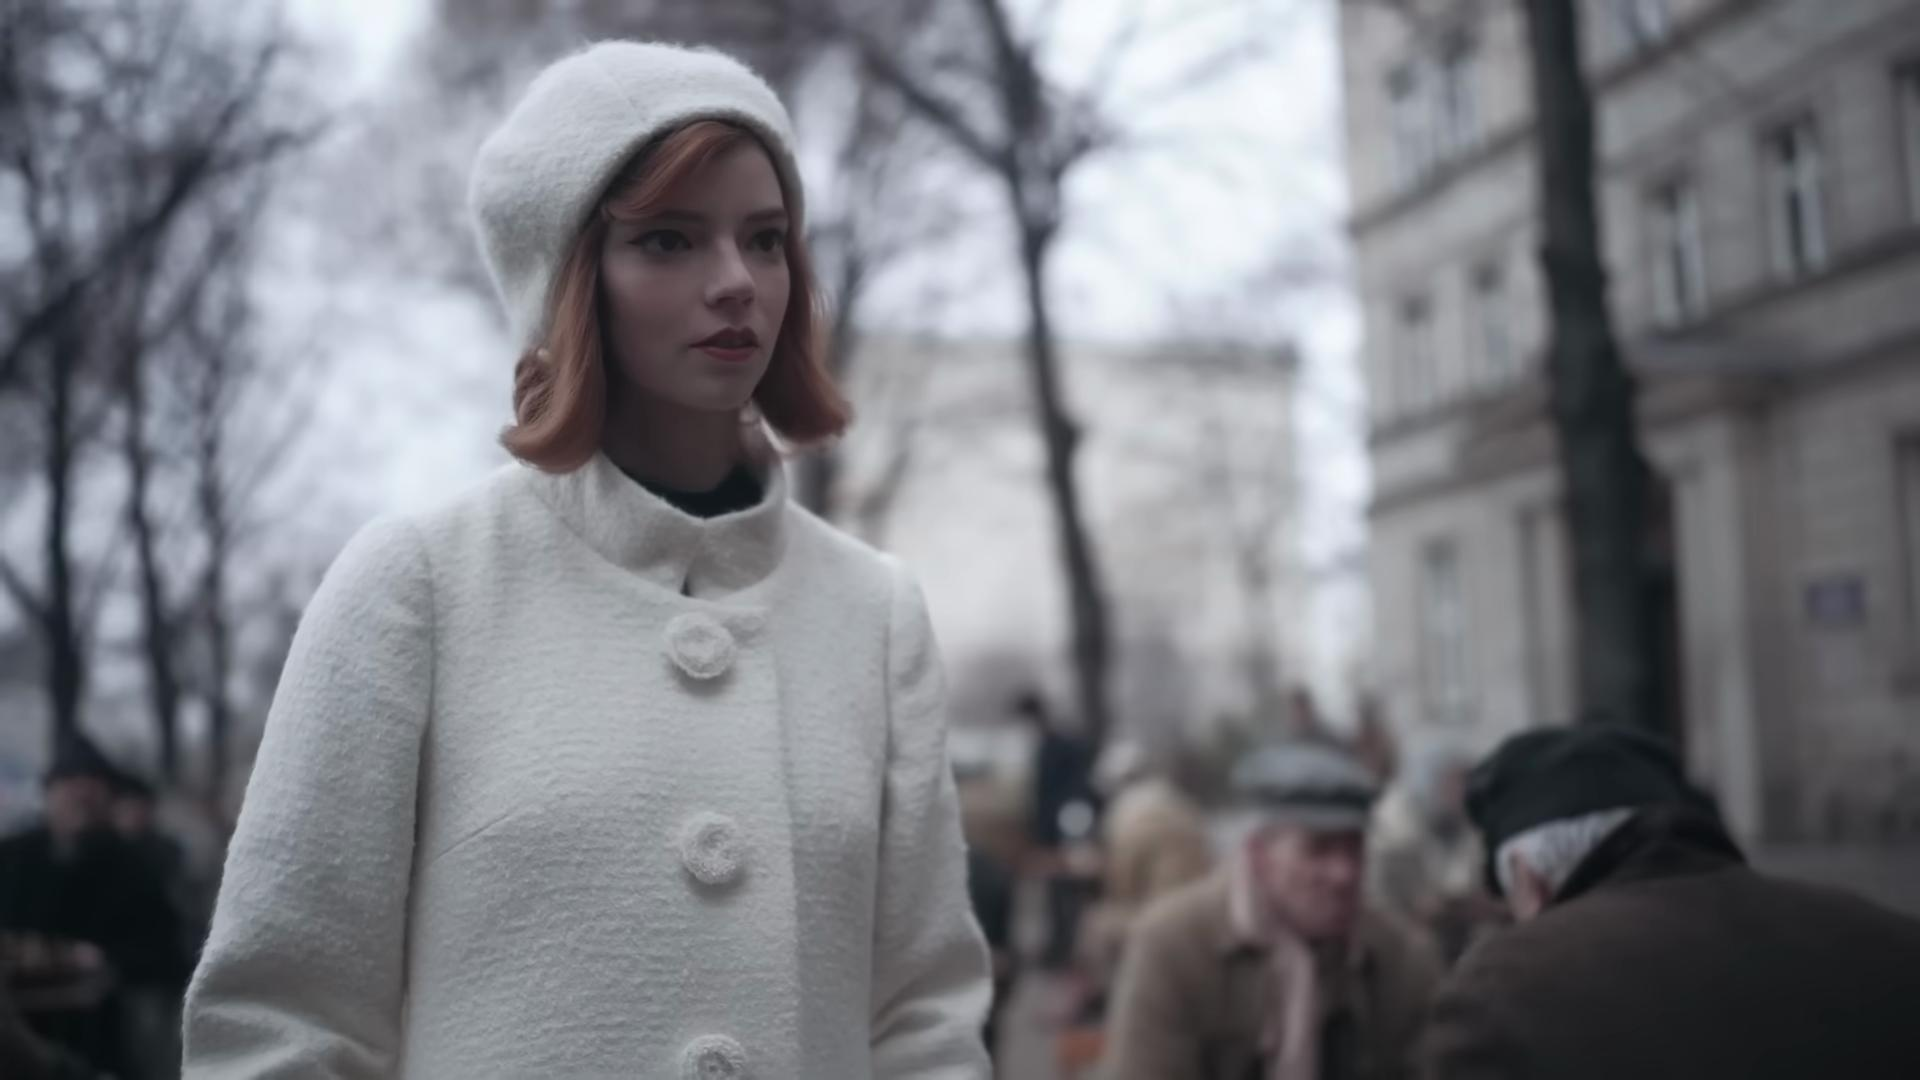
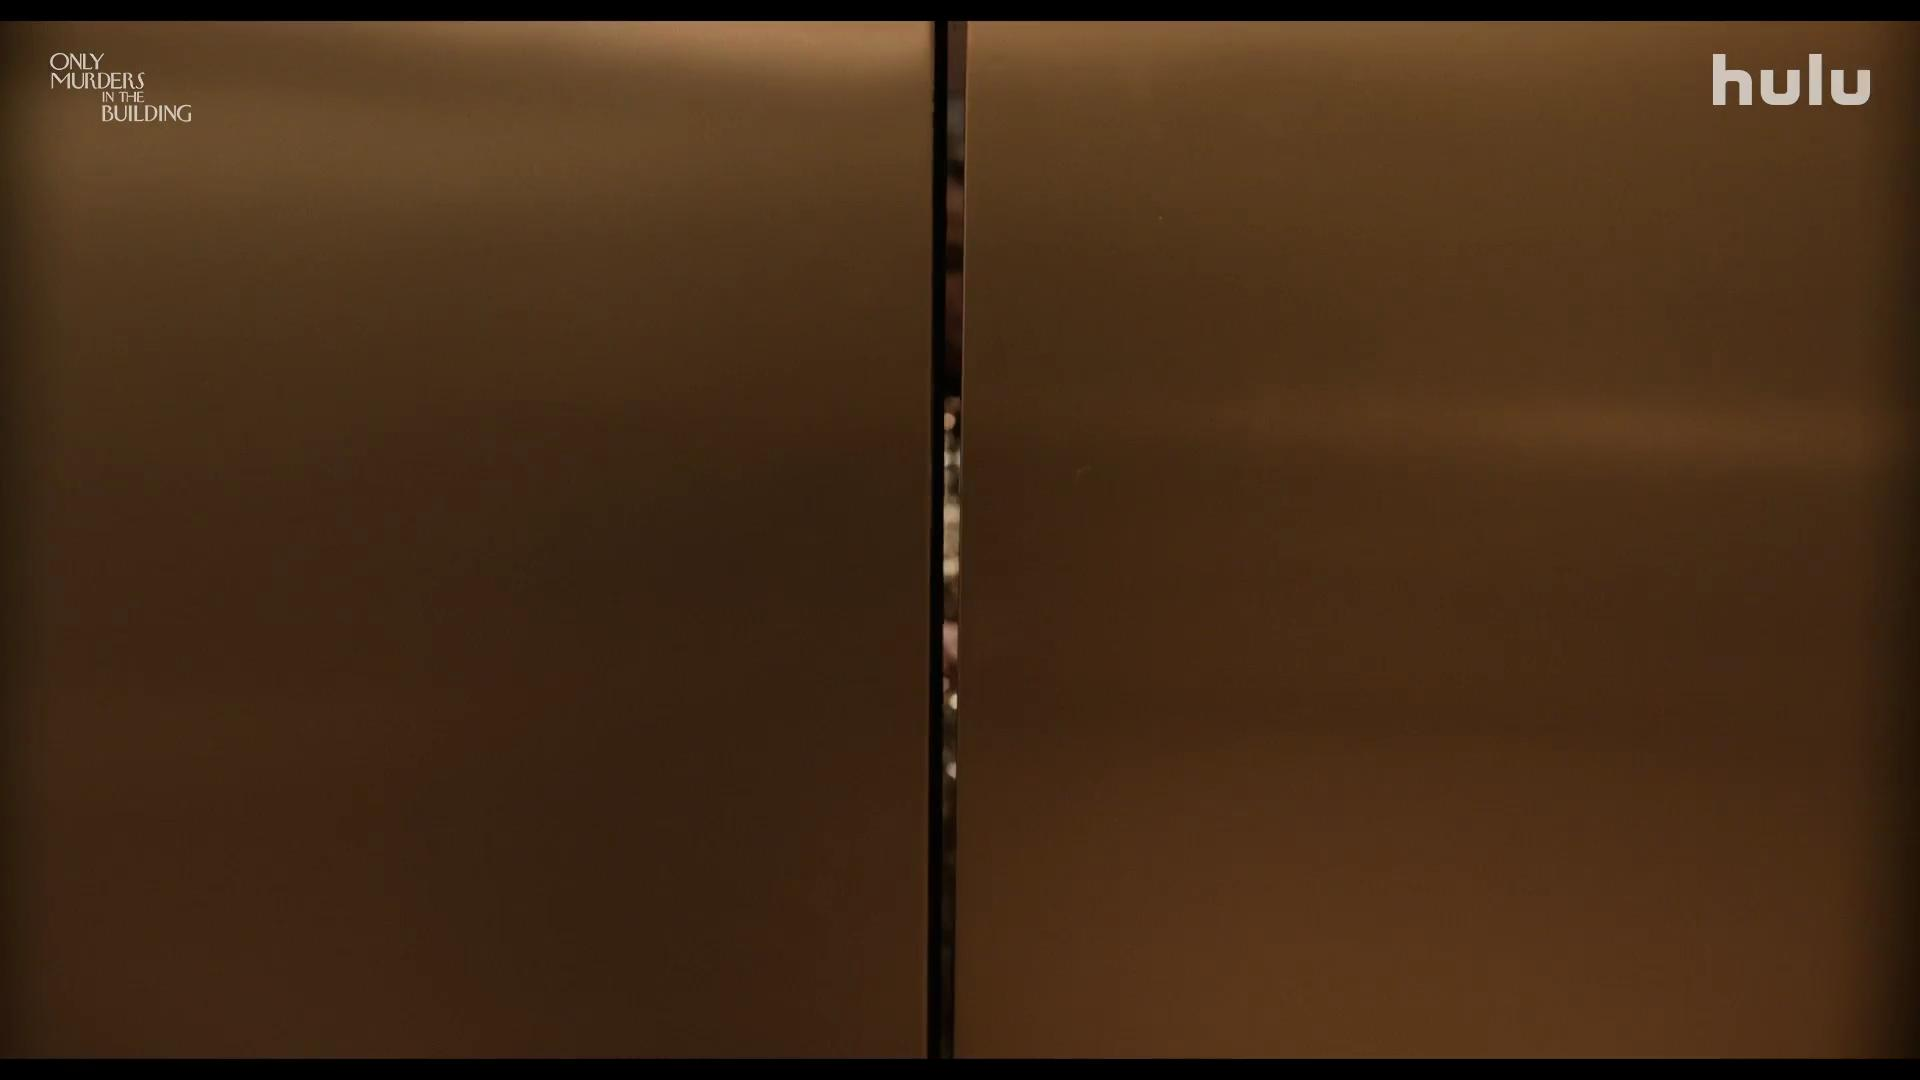

In [18]:
scene_view.where(scene_view.pos == 7).select(
    scene_view.video_segment,
    scene_view.transcript_text,
    trailer_prompt=trailer_prompt_expr
).collect()

So now we've called the Gemini API for two scenes (one from each video), but our view table remains unchanged:

In [19]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
    beginning_frame            Image         video_segment.extract_frame(timestamp=0.5)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

Now let's actually add the prompt, which calls the Gemini API for each scene and saves the output in a column in our table persistently. This is slow (>1.5 minutes) because we told Pixeltable to use Gemini's published rate limits of 10 requests per minute max. If no rate limit is configured, Pixeltable uses a default of 600 requests per minute.

In [20]:
scene_view.add_computed_column(
    trailer_prompt=trailer_prompt_expr,
    if_exists='replace'
)

Added 18 column values with 0 errors in 103.39 s (0.17 rows/s)


18 rows updated.

Now we have stored the LLM-generated prompts that we'll give to our *next* model in our table:

beginning_frame,trailer_prompt
,"Cold War shadows deepen as a chess master's intense gaze penetrates the board. His face, etched with calculation and concern, anticipates the next move in a high-stakes game."
,"A sea of faces in the cold, their breath misting in the dim light as they watch with anticipation. The weight of the Cold War hangs in the air."
,"Close up on Beth Harmon, her gaze fixed intensely downward, lost in thought, the harsh light creating a chiaroscuro effect against the dark backdrop. Crimson curls frame her face, illuminated by a single source, reflecting in her determined eyes."

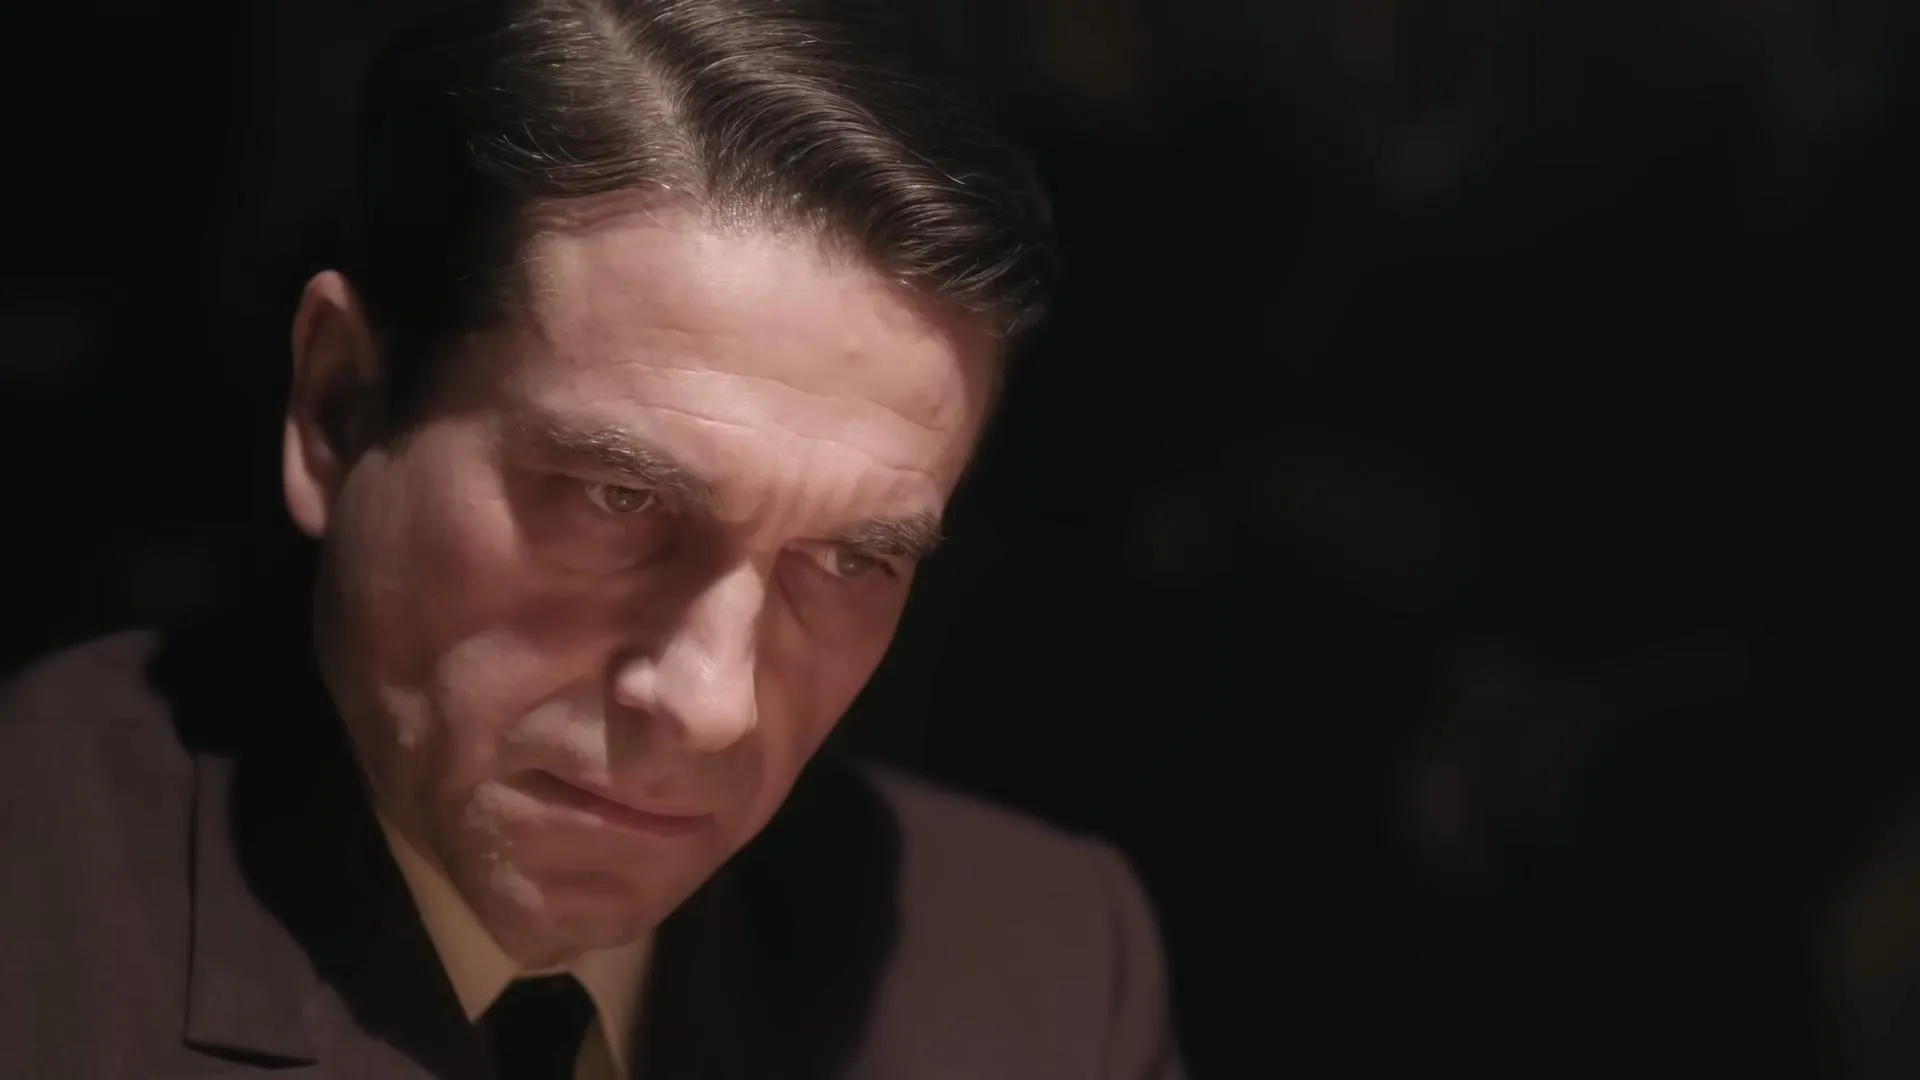
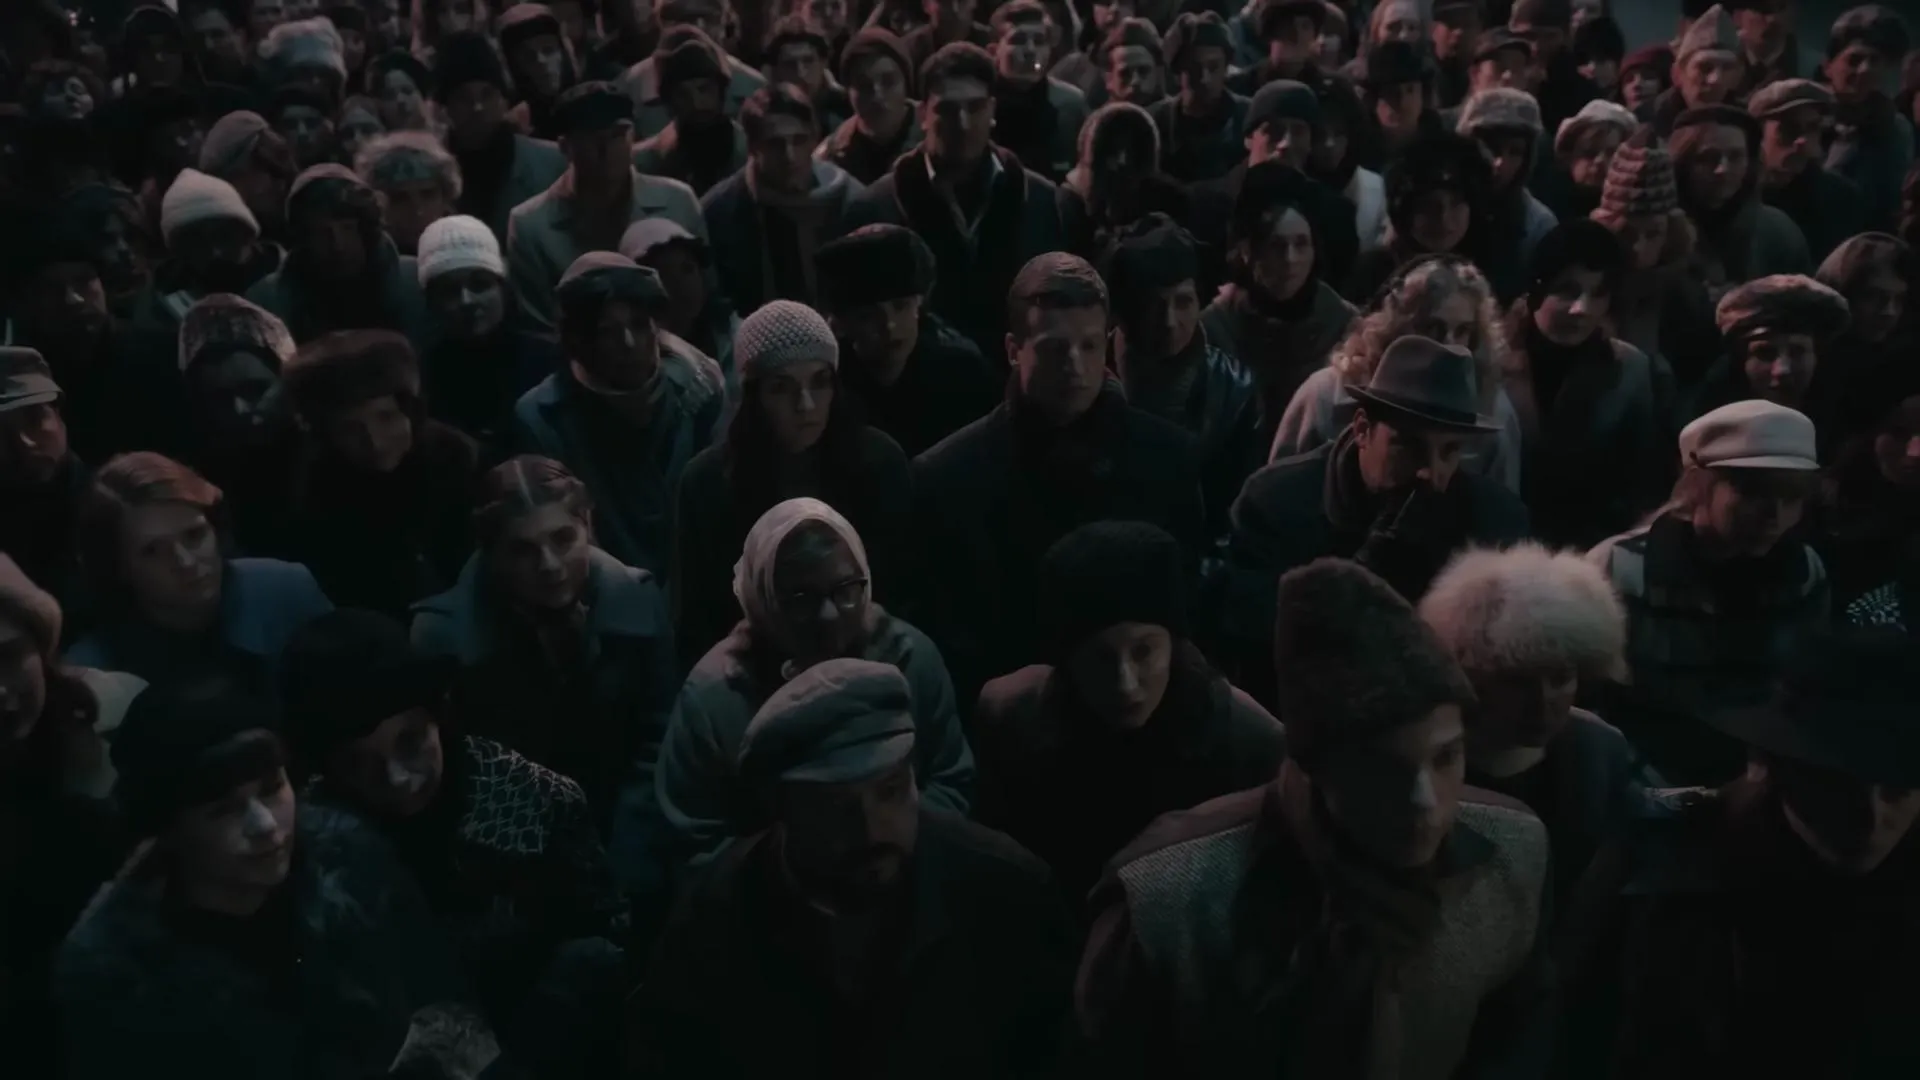
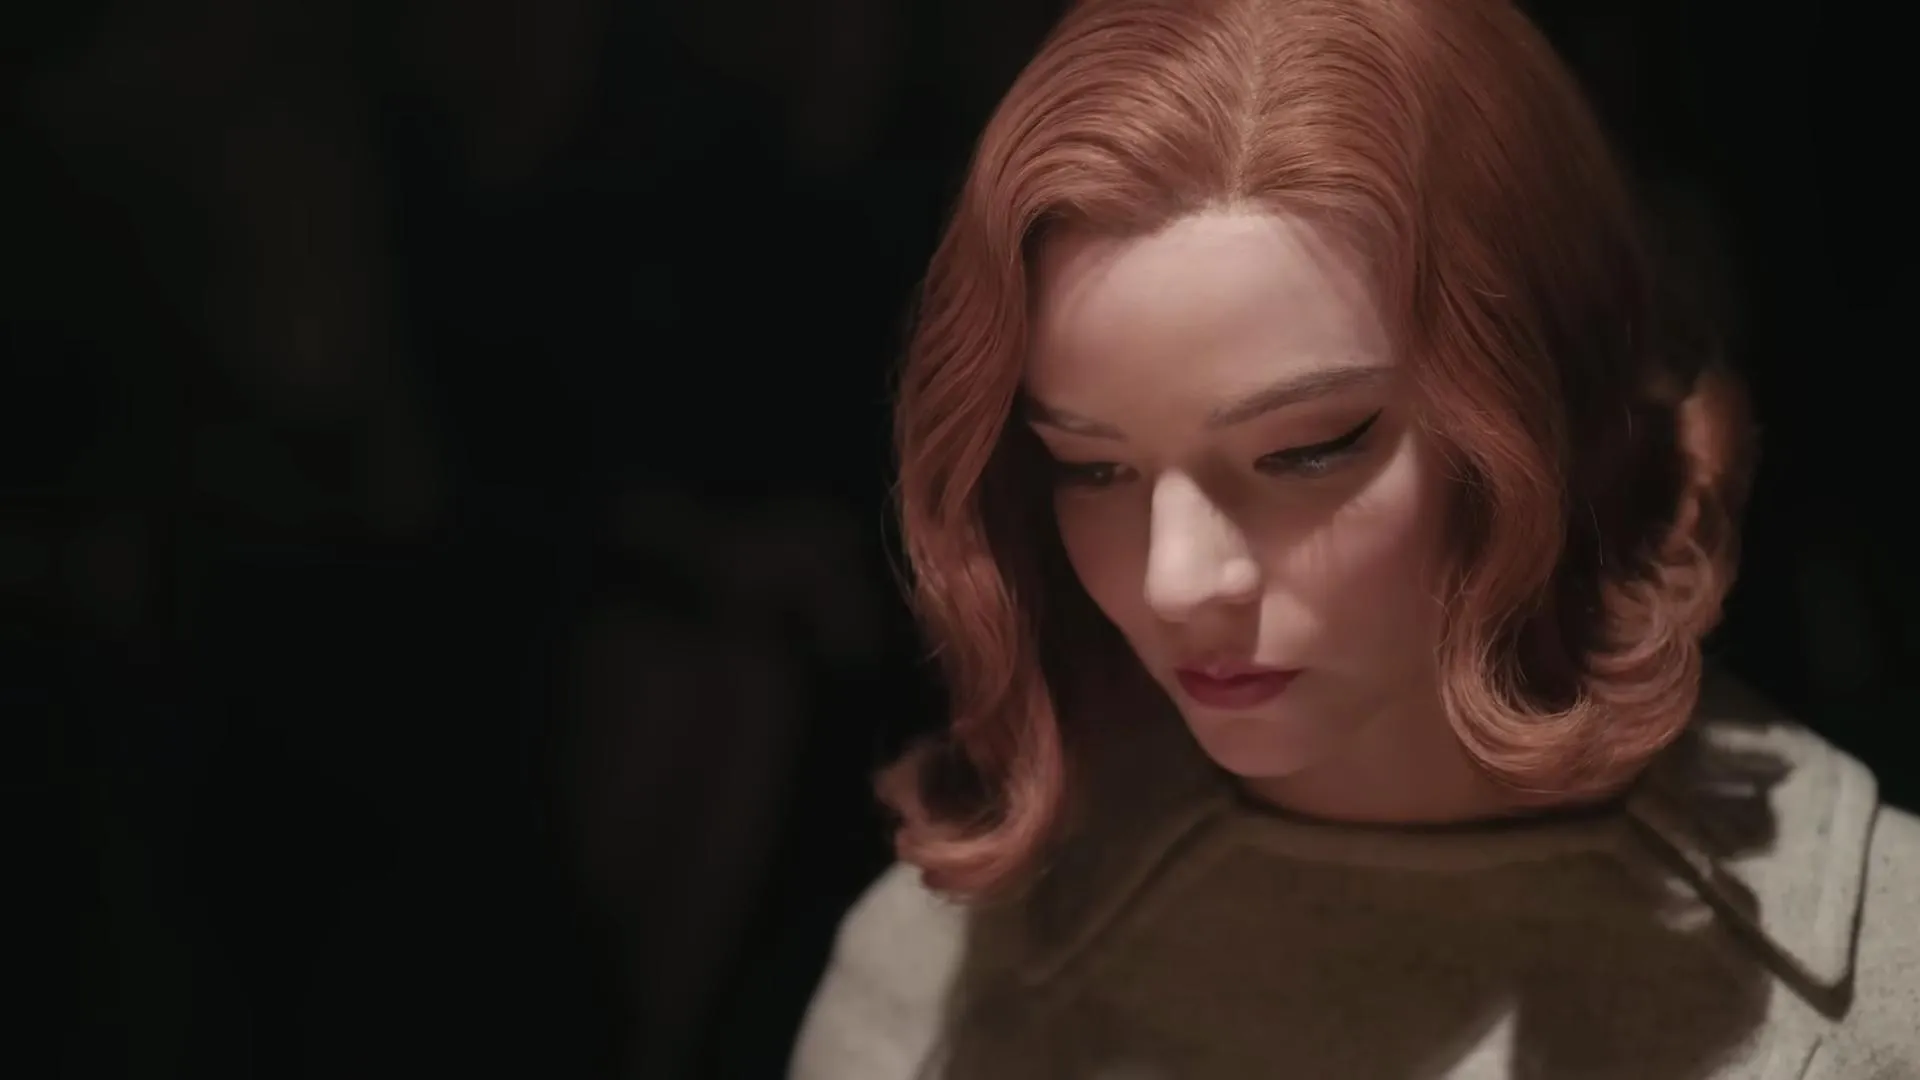

In [21]:
scene_view.select(scene_view.beginning_frame, scene_view.trailer_prompt).head(3)

beginning_frame,trailer_prompt
,"Tight shot of a vintage elevator door, dimly lit, the brass handle gleaming slightly in the low light. The subtle details suggest a hidden story behind the building's closed doors."
,"Three unlikely friends in formal attire ride an elevator, upward gaze, a woman in the center scrolling through her phone, the elevator bathed in warm, claustrophobic light. Anxious energy permeates the confined space as the trio ascends toward an unknown destination."
,"A young woman in a shimmering gold dress stands in a narrow, vintage elevator, her face blurred and uncertain. The warm light casts long shadows, hinting at a hidden darkness."

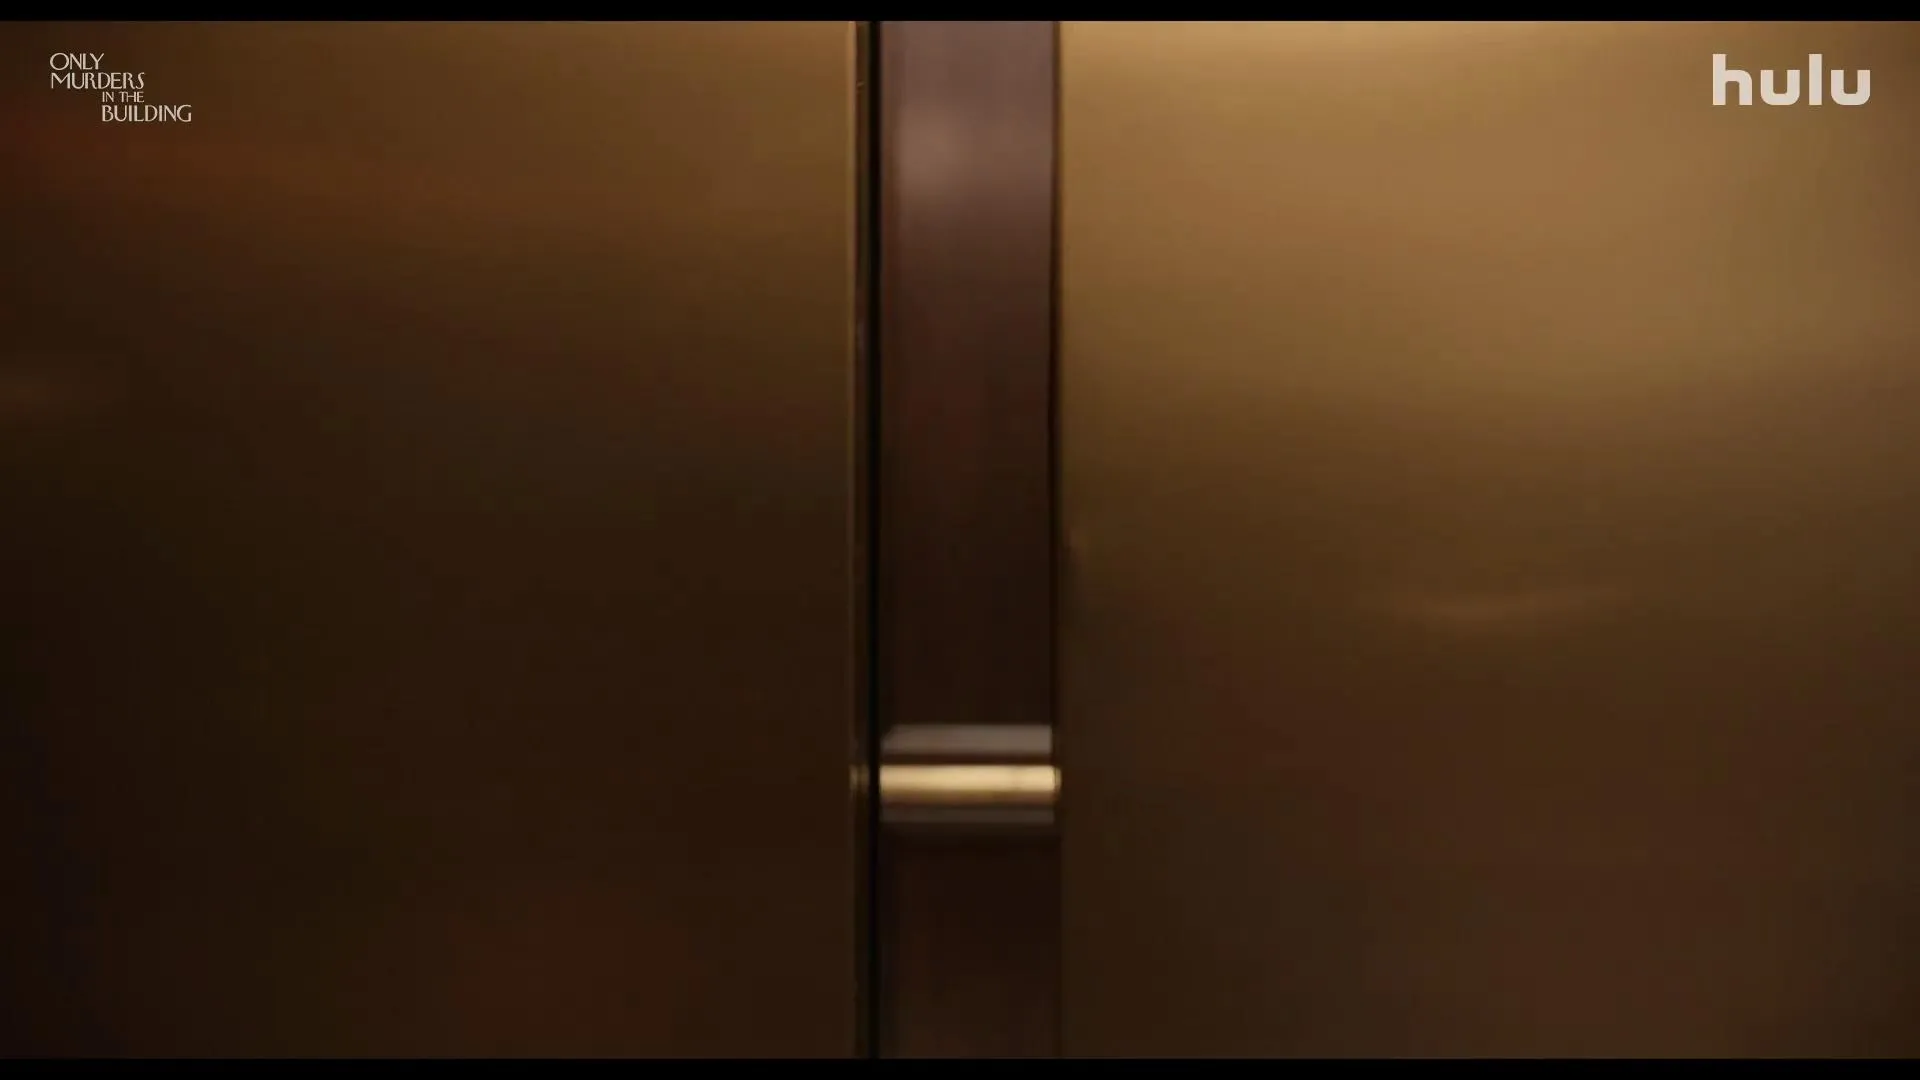
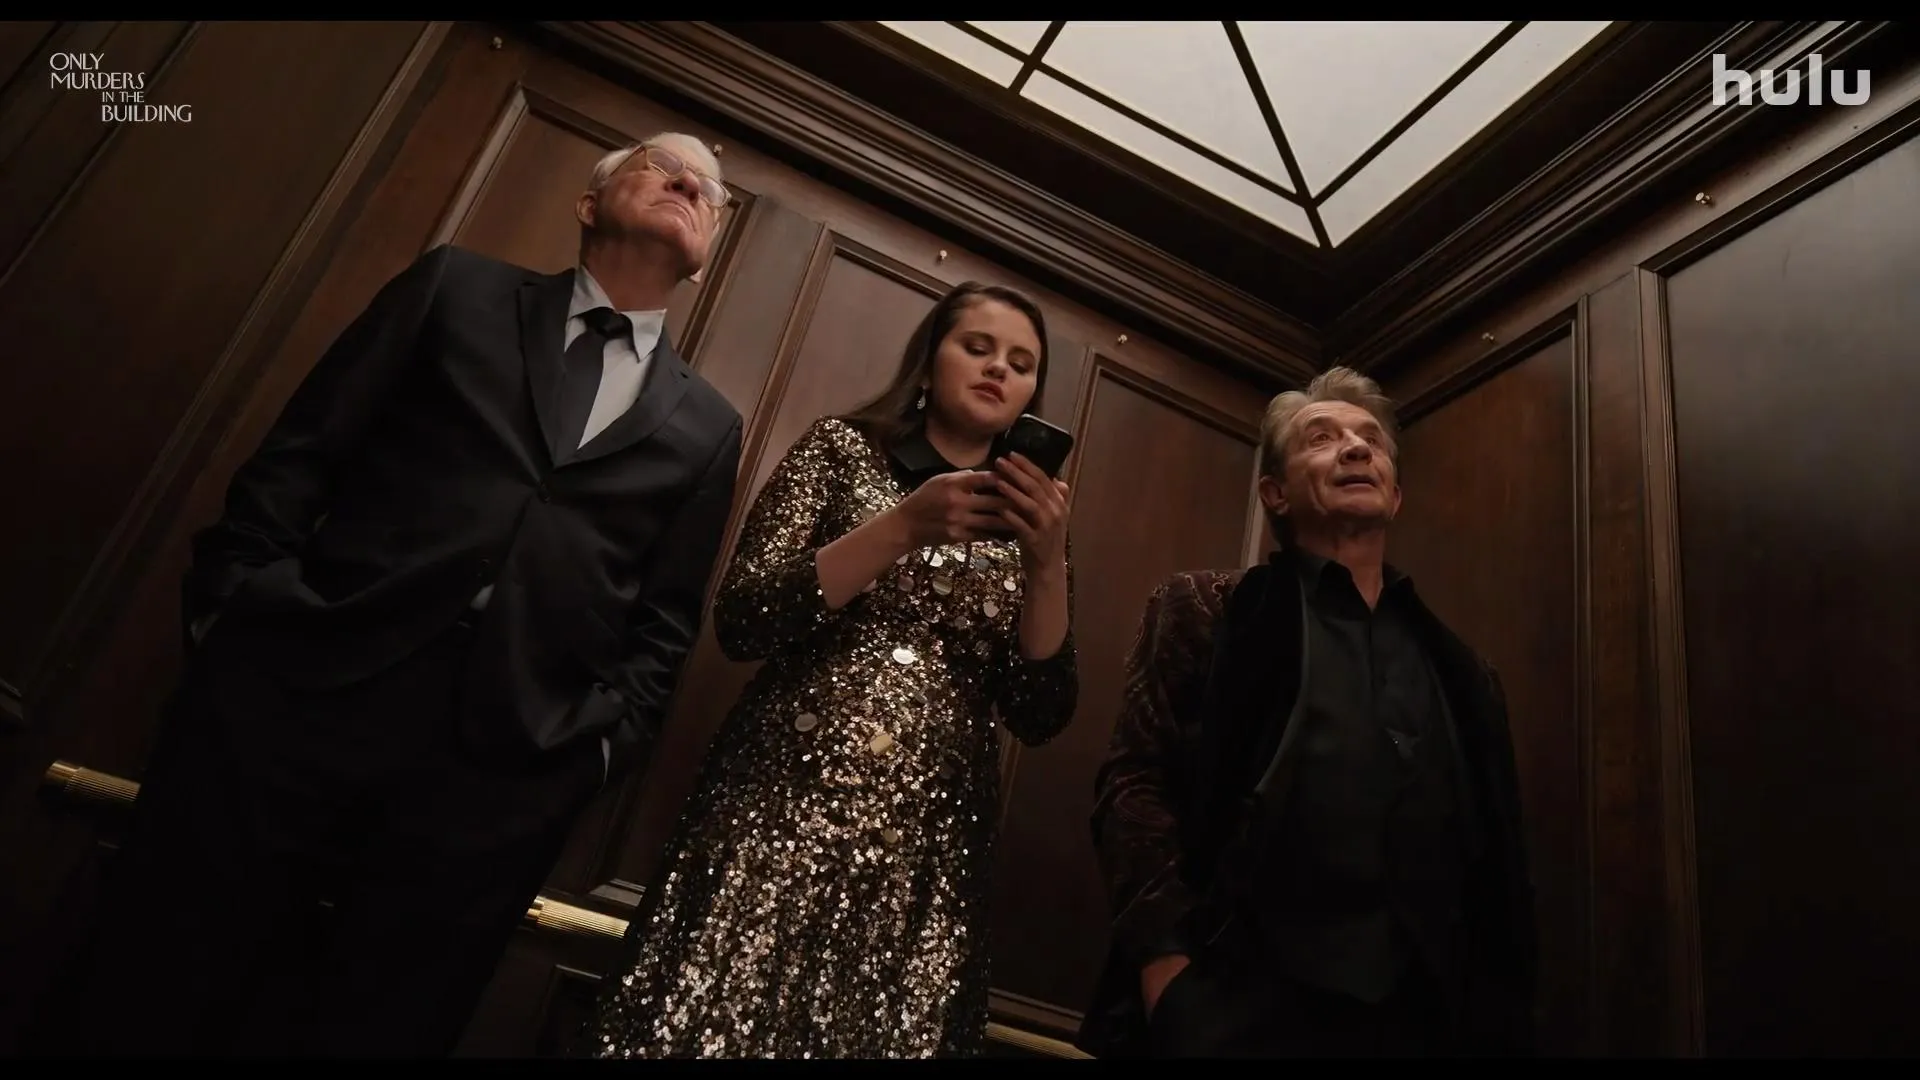
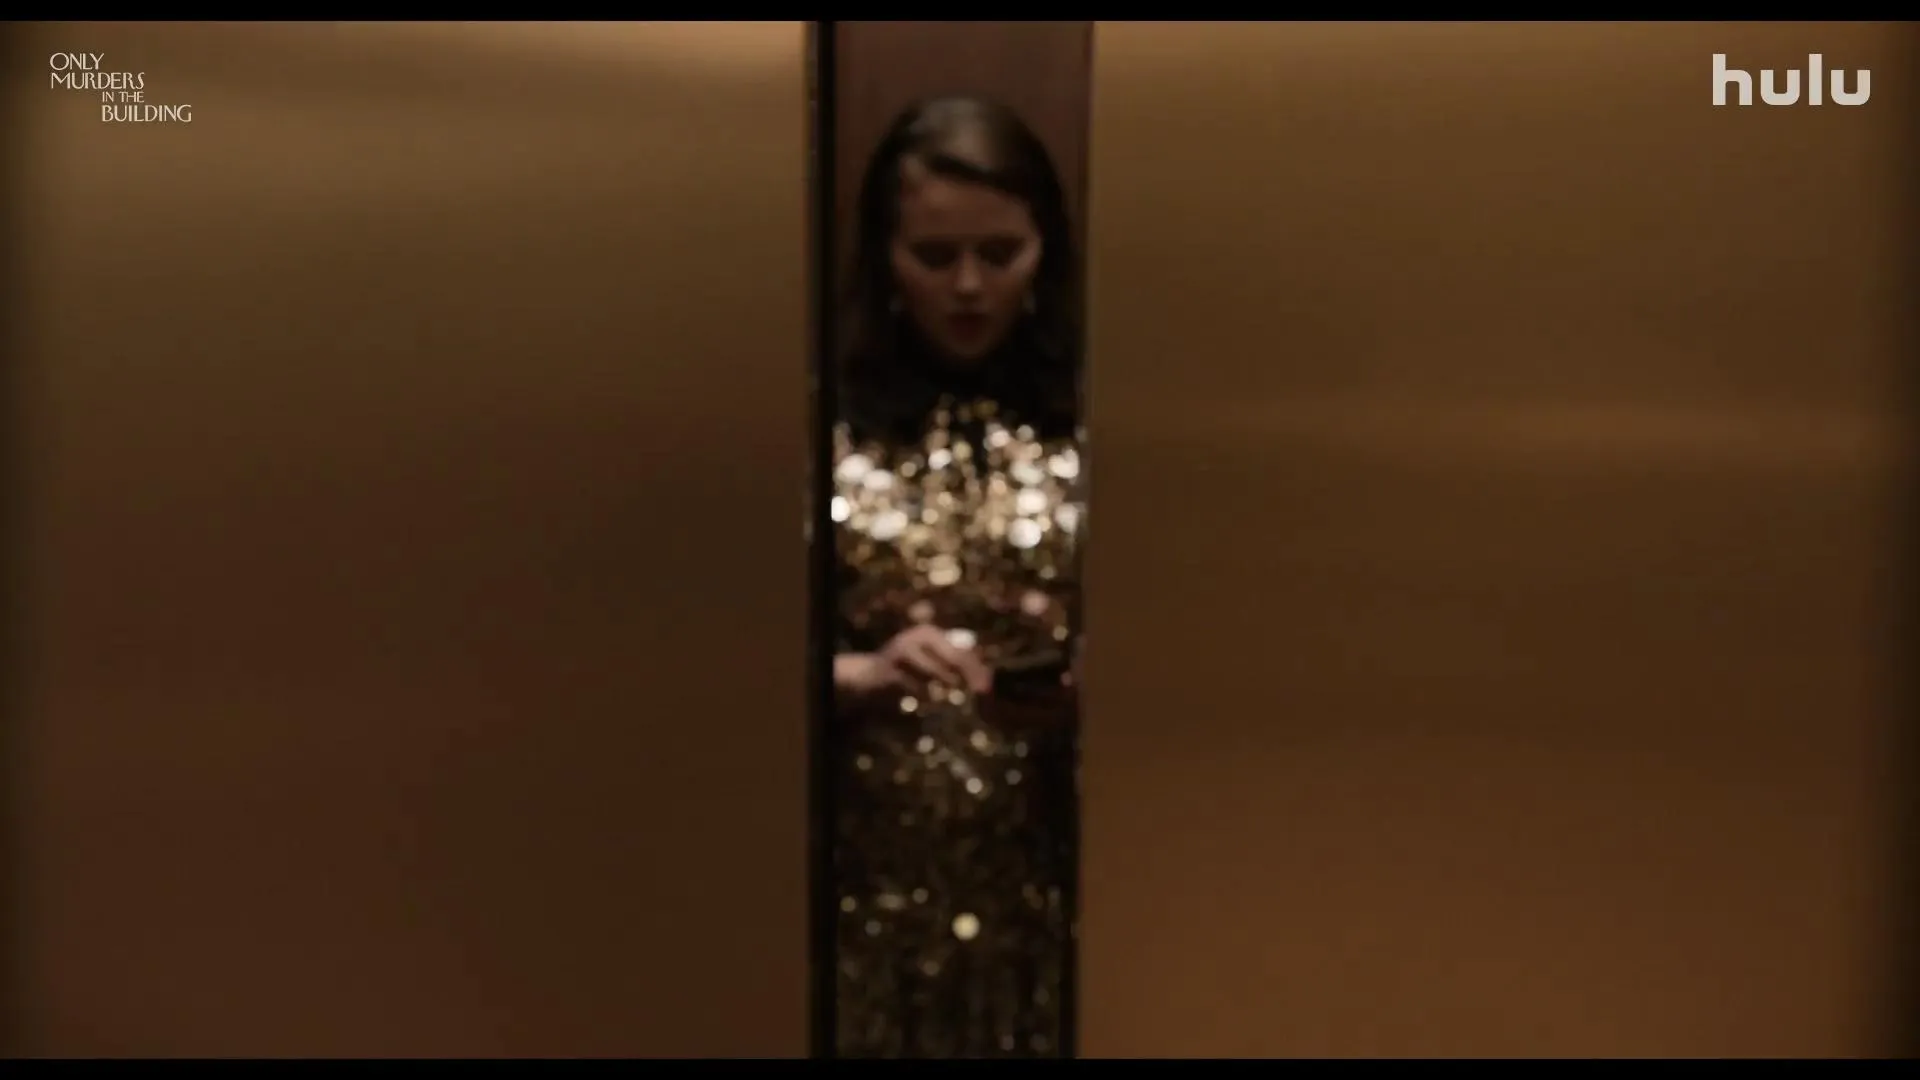

In [22]:
scene_view.select(scene_view.beginning_frame, scene_view.trailer_prompt).tail(3)

If you noticed anything off in the outputs, now would be a great time to edit your prompt generation expression to refine the Gemini output to get it just right. You might need the prompt to be structured in a specific format, or you could ask the LLM to include historically accurate details that would make the time period more salient.

Here are all the prompts we just generated with Gemini:

In [23]:
scene_view.select(
    scene_view.pos,
    scene_view.title,
    scene_view.trailer_prompt
).order_by(scene_view.title, scene_view.pos).collect()

pos,title,trailer_prompt
0,Only Murders in the Building,"Dim, flickering hallway light reveals dust motes dancing in the air of an old New York City apartment building. A shadowy figure lurks in the distance, receding into the darkness."
1,Only Murders in the Building,"A vintage countdown leader ticks down in high contrast black and white, the grain of the film stock adding texture, a sense of urgency. The number ""5"" pulses with an ominous energy, a prelude to chaos amidst the silent film's nostalgic aesthetic."
2,Only Murders in the Building,"Grainy, deteriorated film of a young girl with pigtails, her eyes wide with fear. The flickering light reveals the dark secret hidden behind her innocent gaze."
3,Only Murders in the Building,"A body, partially submerged in a shimmering blue tub, struggles in the darkness. A single shaft of light illuminates the haunted face, caught in a moment of profound reckoning."
4,Only Murders in the Building,"Dimly lit Upper West Side apartment, a fedora perched atop an ornate, glowing lamp, casting shadows on antique curiosities. The air thick with secrets and the scent of old money, hinting at the darkness hidden behind closed doors."
5,Only Murders in the Building,"Tight shot of a vintage elevator door, dimly lit, the brass handle gleaming slightly in the low light. The subtle details suggest a hidden story behind the building's closed doors."
6,Only Murders in the Building,"Three unlikely friends in formal attire ride an elevator, upward gaze, a woman in the center scrolling through her phone, the elevator bathed in warm, claustrophobic light. Anxious energy permeates the confined space as the trio ascends toward an unknown destination."
7,Only Murders in the Building,"A young woman in a shimmering gold dress stands in a narrow, vintage elevator, her face blurred and uncertain. The warm light casts long shadows, hinting at a hidden darkness."
0,The Queens Gambit,"Cold War shadows deepen as a chess master's intense gaze penetrates the board. His face, etched with calculation and concern, anticipates the next move in a high-stakes game."
1,The Queens Gambit,"A sea of faces in the cold, their breath misting in the dim light as they watch with anticipation. The weight of the Cold War hangs in the air."


Let's look at our table history again:

In [24]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,19,2026-01-27 03:21:21.753114+00:00,None,schema,0,18,0,0,Added: trailer_prompt
1,18,2026-01-27 03:20:14.326821+00:00,None,schema,0,18,0,0,Added: beginning_frame
2,17,2026-01-27 03:19:54.814359+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
3,16,2026-01-27 03:19:54.805257+00:00,None,schema,0,18,0,0,Deleted: trailer_prompt
4,15,2026-01-27 03:19:54.795392+00:00,None,schema,0,18,0,0,Deleted: trailer_image
5,14,2026-01-27 02:11:50.513707+00:00,None,schema,0,18,0,0,Added: trailer_image
6,13,2026-01-27 01:58:21.501940+00:00,None,schema,0,18,0,0,Added: trailer_prompt
7,12,2026-01-27 01:56:48.072202+00:00,None,schema,0,18,0,0,Added: beginning_frame
8,11,2026-01-27 01:51:52.219388+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
9,10,2026-01-27 01:17:23.320129+00:00,None,schema,0,18,0,0,Added: beginning_frame


## 03 - Create New Content

Now you can generate visual content from your trailer prompts. This section is a "choose your own adventure" style, based on how you want to use your Gemini tokens. At the time of this workshop, the code we provide should keep you safely in the free tier. You have three options:

- **Option A: Generate Images** (faster, cheaper - good for testing) with Gemini's `imagen-4.0-generate-001` model
- **Option B: Generate Videos from Prompt + Image** (slower, more expensive - production quality) with Gemini's `veo-3.1-generate-preview` model
- **Option C: Generate Videos from Image Only** (slower, more expensive - simpler approach) with Gemini's `veo-3.1-generate-preview` model

These examples use `.select().where()` to test generation on a single scene. This is an **query** - it runs once and returns results without storing anything. This is perfect for testing expensive operations before applying them to all rows.

Later, you'll see how to add image generation as a computed column to process all scenes automatically and store the results persistently.

**Note on video generation:** Frames are resized from 1920x1080 to 640x360 before being sent to Gemini. Gemini's API limit for combined text and image data is 100MB per request (recently increased from 20MB). We resize to stay well under this limit.

In Pixeltable, you can chain image operations like [`.resize()`](https://docs.pixeltable.com/sdk/latest/image#udf-resize) on image columns - you don't have to save the resized image to disk or create a separate column to include it in your API call to Gemini.

### OPTION A: Generate an Image

Test on one scene first. Once you verify the output quality, you can add it as a computed column (see Section 04). In this example, we are creating a variable `scene_image` to hold the result of the query. This is an in memory result and does not change your stored table. It is also limited: you can pull this result back up within your Python session only. We'll persist outputs in the next section.

In [25]:
scene_image = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    )
).collect()

pos,trailer_prompt,trailer_image
7,"A young woman in a shimmering gold dress stands in a narrow, vintage elevator, her face blurred and uncertain. The warm light casts long shadows, hinting at a hidden darkness.",
7,"A lone figure in white stands poised against the muted gray backdrop of a Cold War-era park, a chessboard battle brewing in the air. Her gaze is sharp, calculating, a silent storm of intellect amidst the gathering clouds.",

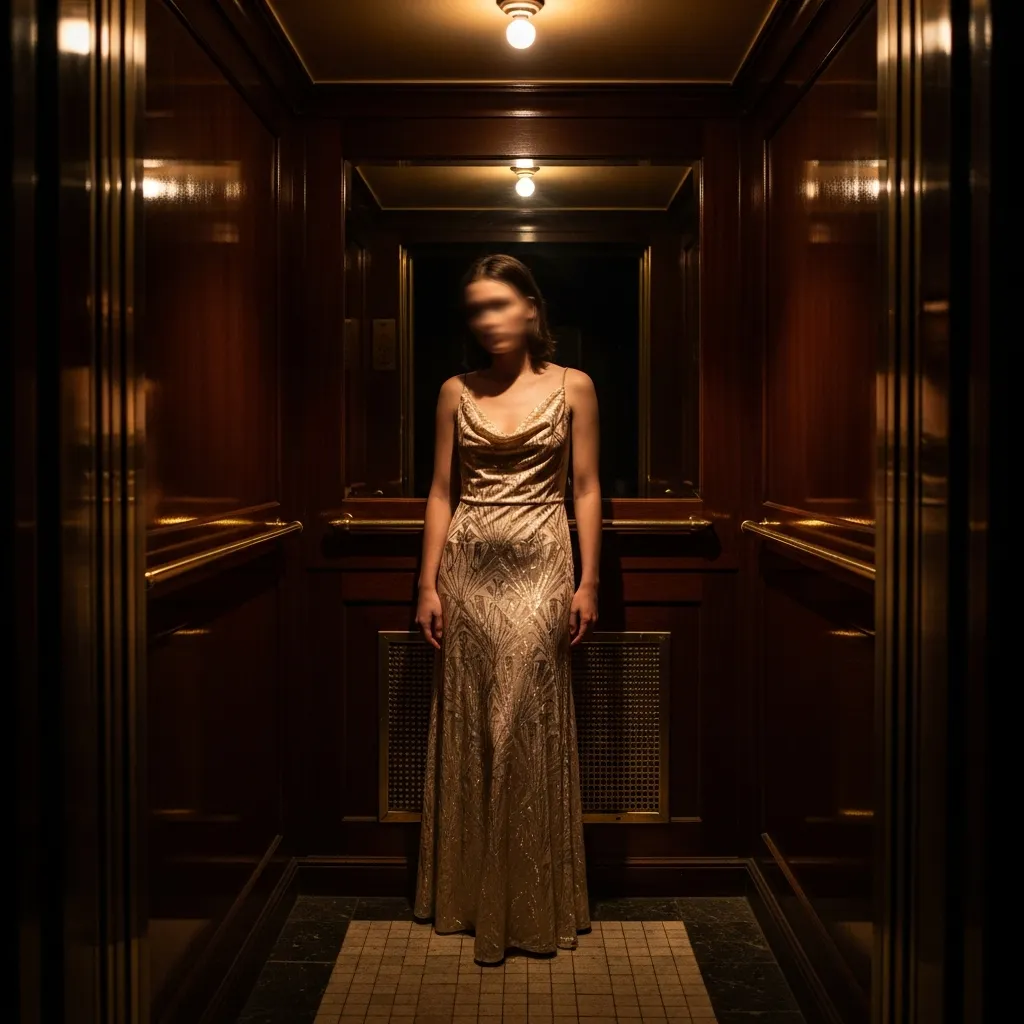
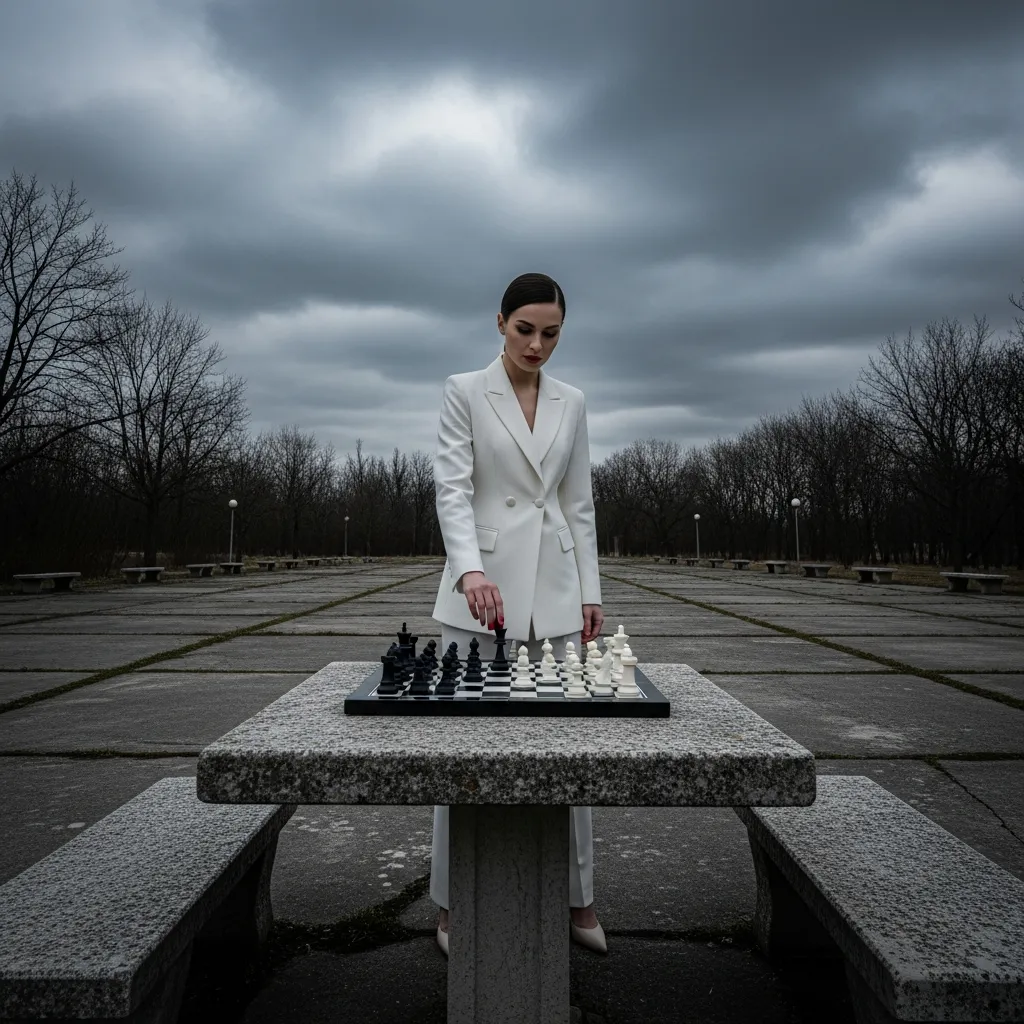

In [26]:
scene_image

### OPTION B: Generate a Video from Prompt + Image

Video generation is slower and more expensive than image generation. This option animates a frame based on your trailer prompt. Again, we'll save the results of this query in memory as `scene_trailer`.

In [27]:
scene_trailer = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.trailer_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.trailer_prompt,
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

pos,trailer_prompt,trailer_video
7,"A young woman in a shimmering gold dress stands in a narrow, vintage elevator, her face blurred and uncertain. The warm light casts long shadows, hinting at a hidden darkness.",
7,"A lone figure in white stands poised against the muted gray backdrop of a Cold War-era park, a chessboard battle brewing in the air. Her gaze is sharp, calculating, a silent storm of intellect amidst the gathering clouds.",

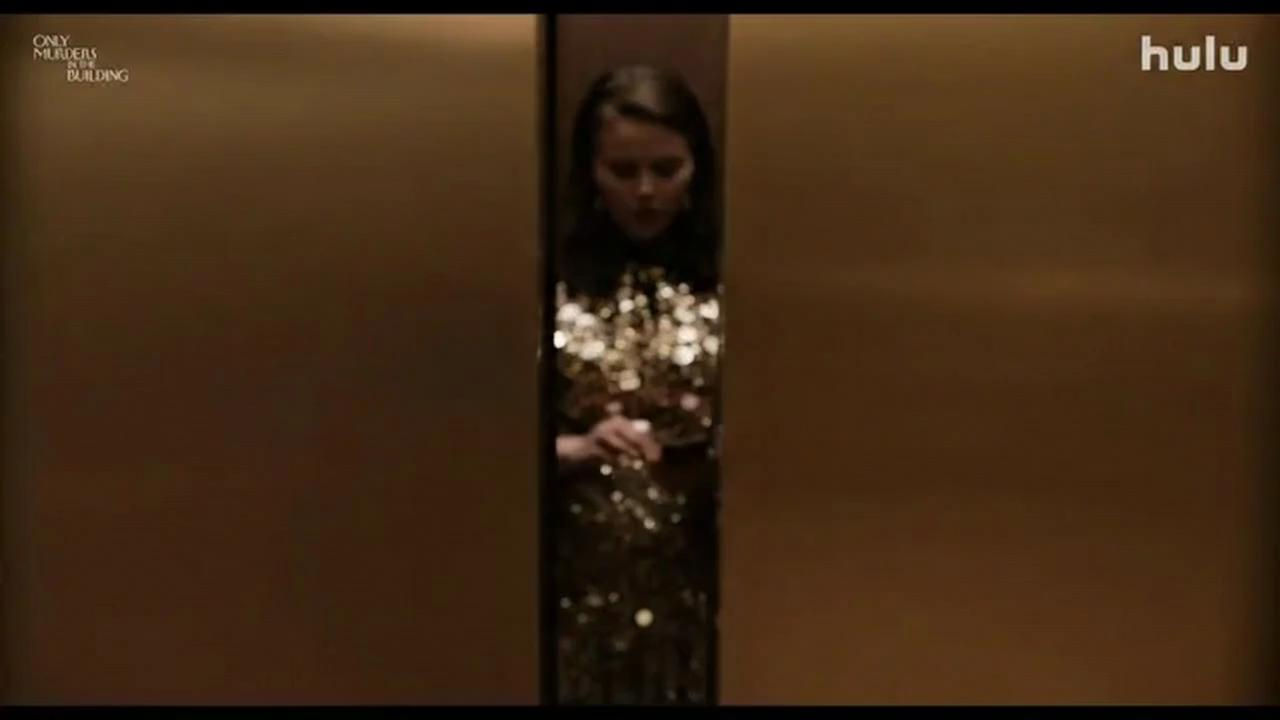
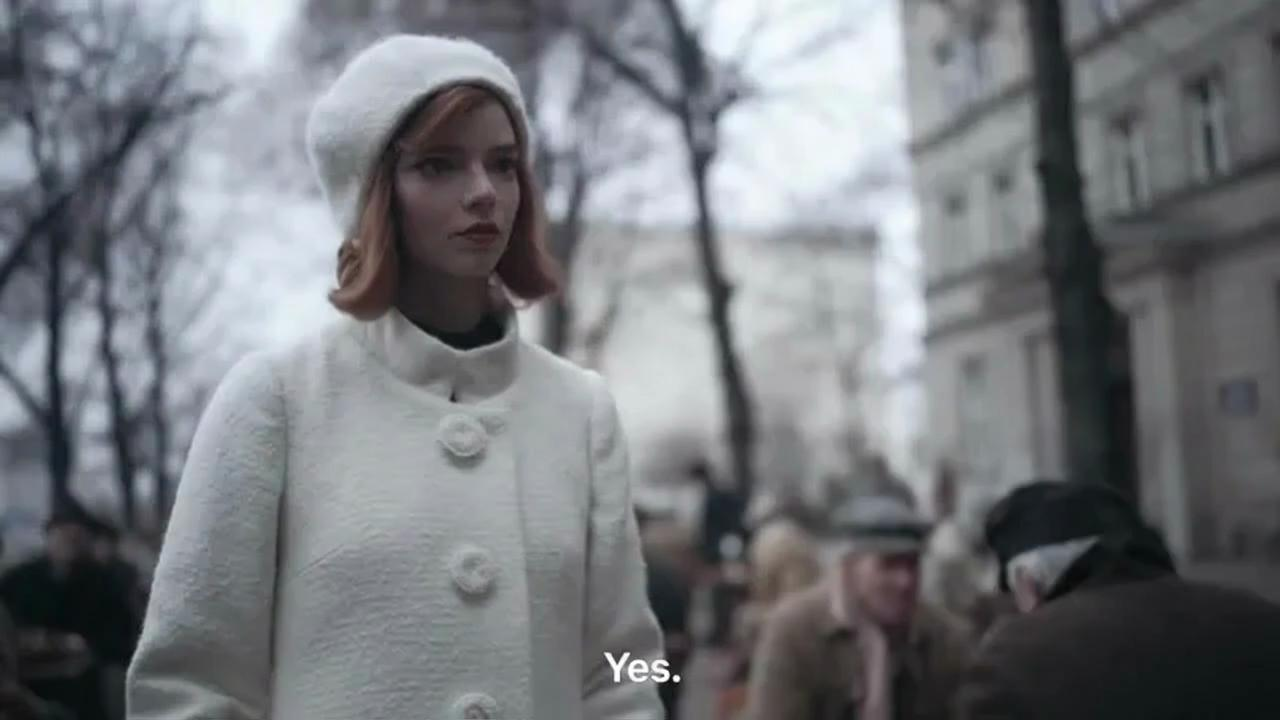

In [28]:
scene_trailer

### OPTION C: Animate an Image (No Prompt)

This simpler approach animates the frame without a text prompt - just the image itself.

In [29]:
scene_animation = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.beginning_frame,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.beginning_frame.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

In [ ]:
scene_animation

You've tested image and video generation on individual scenes in queries using `.select().where()`. 

But what if you want to generate images for **all** scenes automatically, and save them persistently in your scene view?

## 04 - Generate Across All Scenes

You've tested image generation on a single scene using `.select().where()`. Now you'll add it as a computed column to process all scenes automatically.

**What changes when you use a computed column:**

1. **Processes all rows**: Generates images for all rows (here, we have 1 row per scene for each video) with a unique prompt per row, without loops or iteration code
2. **Parallel execution**: Pixeltable parallelizes API calls automatically - faster than sequential processing
3. **Persistent storage**: Results are stored in the table, not just returned as query results
4. **Incremental updates**: If you add new videos to the base table, the scene detection and image generation cascade automatically

Here we will generate just images with the `imagen-4.0-generate-001` model. At the time of this workshop, Gemini limits this model to 10 requests per minute with a max of 70 images per day, so you can run this code on all rows within the free tier.

If you want to test out video generation and have your billing setup, you can adapt our query code above to use computed columns instead. You'll want to configure Pixeltable with provider-specific rate limits: https://docs.pixeltable.com/platform/configuration#rate-limit-configuration

This computed column will automatically generate trailer images for all scenes - it takes about 2 minutes to execute because we need to stay under the Gemini rate per minute limit of 10. Let's check our rate limits are set:

In [30]:
from pixeltable.config import Config
config = Config.get()
config._Config__config_dict.get('imagen', {}).get('rate_limits')

{'imagen-4.0-generate-001': 10}

In [31]:
scene_view.add_computed_column(
    trailer_image=pxtf.gemini.generate_images(
        prompt=scene_view.trailer_prompt,
        model='imagen-4.0-generate-001'
    ),
    if_exists='replace',
    on_error='ignore'
)

Added 18 column values with 0 errors in 110.80 s (0.16 rows/s)


18 rows updated.

**What happens when you execute this code:**

We've created a **declarative workflow** with three computed columns that form a processing pipeline:

1. `beginning_frame` - Extracts a frame from each video segment
2. `trailer_prompt` - Generates a text description from the frame (multimodal AI)
3. `trailer_image` - Generates an image from the text description (text-to-image AI)

Each computed column builds on the previous one. Pixeltable handles the orchestration - it knows the dependencies and executes them in the correct order automatically.

Let's take a look at our collection of generated images:

pos,trailer_prompt,trailer_image
0,"Dim, flickering hallway light reveals dust motes dancing in the air of an old New York City apartment building. A shadowy figure lurks in the distance, receding into the darkness.",
1,"A vintage countdown leader ticks down in high contrast black and white, the grain of the film stock adding texture, a sense of urgency. The number ""5"" pulses with an ominous energy, a prelude to chaos amidst the silent film's nostalgic aesthetic.",
2,"Grainy, deteriorated film of a young girl with pigtails, her eyes wide with fear. The flickering light reveals the dark secret hidden behind her innocent gaze.",
3,"A body, partially submerged in a shimmering blue tub, struggles in the darkness. A single shaft of light illuminates the haunted face, caught in a moment of profound reckoning.",
4,"Dimly lit Upper West Side apartment, a fedora perched atop an ornate, glowing lamp, casting shadows on antique curiosities. The air thick with secrets and the scent of old money, hinting at the darkness hidden behind closed doors.",
5,"Tight shot of a vintage elevator door, dimly lit, the brass handle gleaming slightly in the low light. The subtle details suggest a hidden story behind the building's closed doors.",
6,"Three unlikely friends in formal attire ride an elevator, upward gaze, a woman in the center scrolling through her phone, the elevator bathed in warm, claustrophobic light. Anxious energy permeates the confined space as the trio ascends toward an unknown destination.",
7,"A young woman in a shimmering gold dress stands in a narrow, vintage elevator, her face blurred and uncertain. The warm light casts long shadows, hinting at a hidden darkness.",
0,"Cold War shadows deepen as a chess master's intense gaze penetrates the board. His face, etched with calculation and concern, anticipates the next move in a high-stakes game.",
1,"A sea of faces in the cold, their breath misting in the dim light as they watch with anticipation. The weight of the Cold War hangs in the air.",

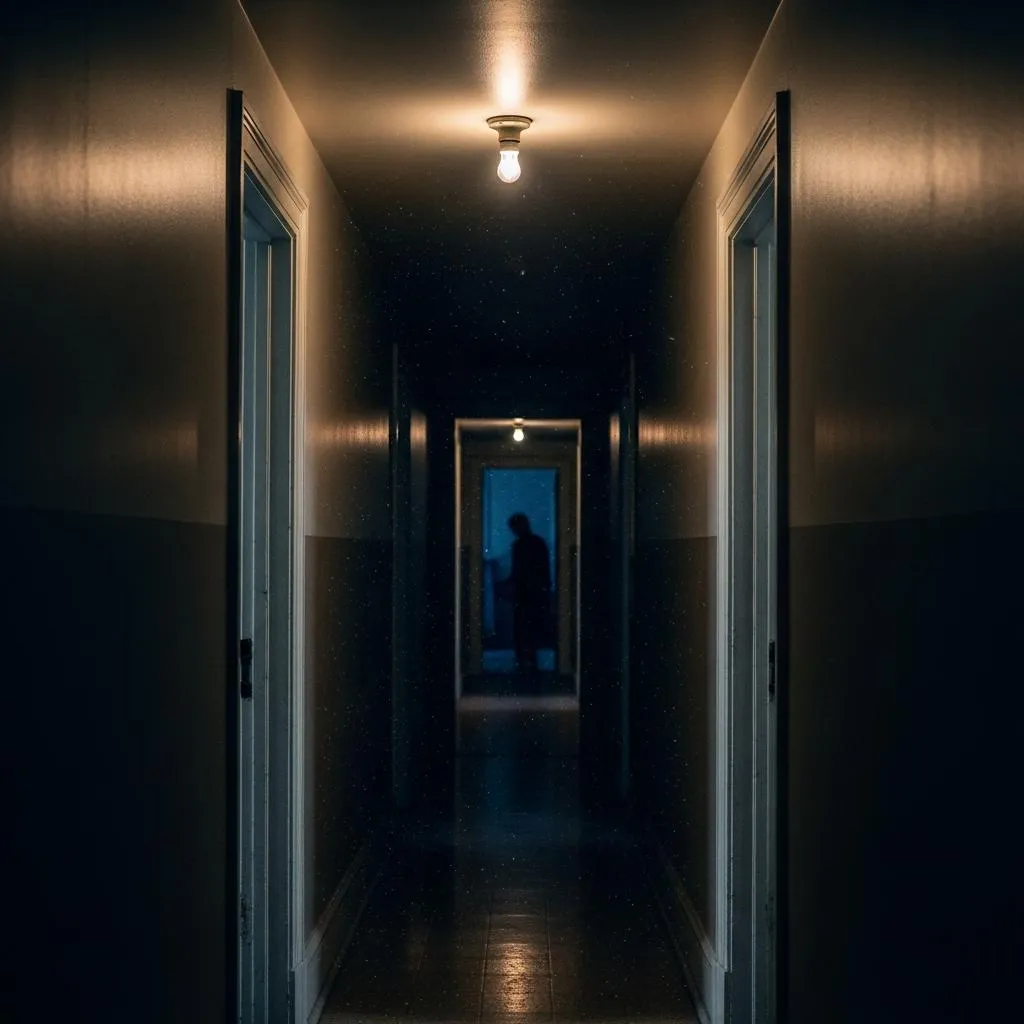
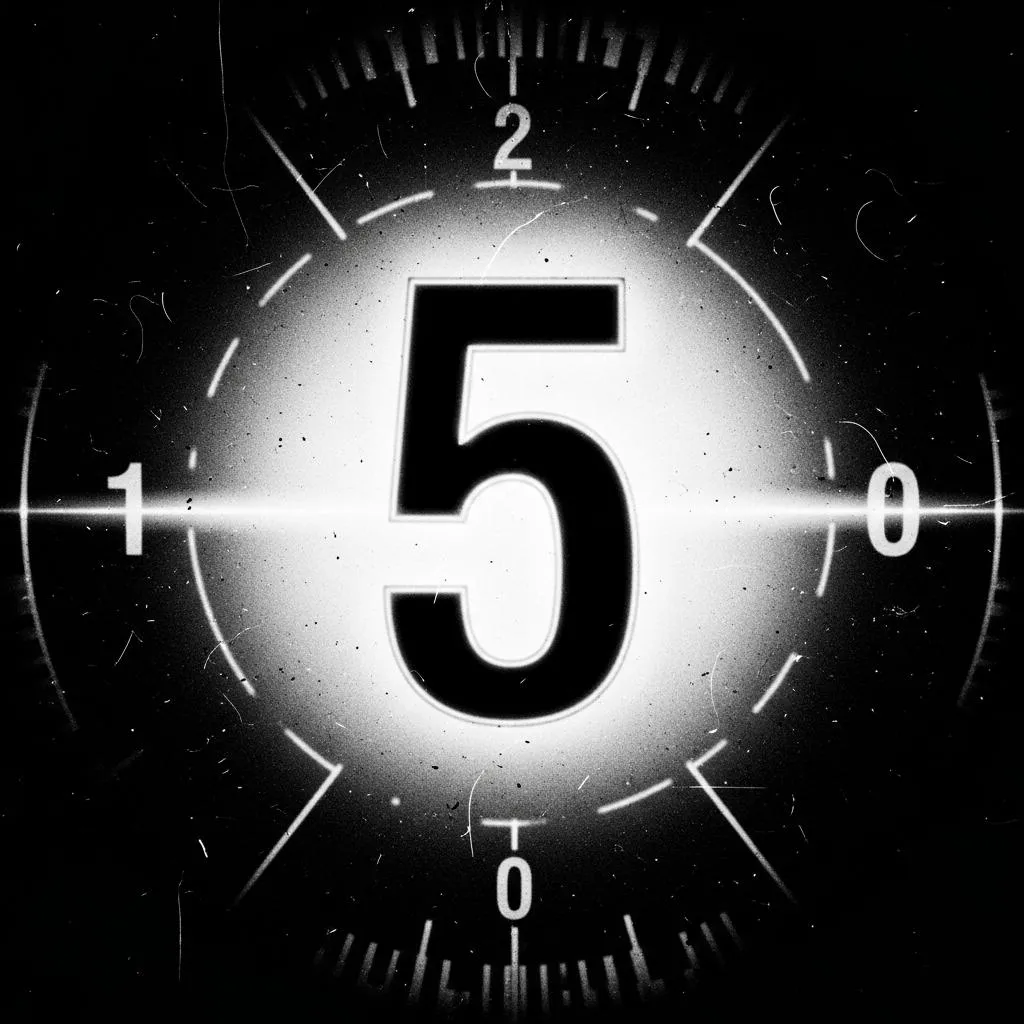
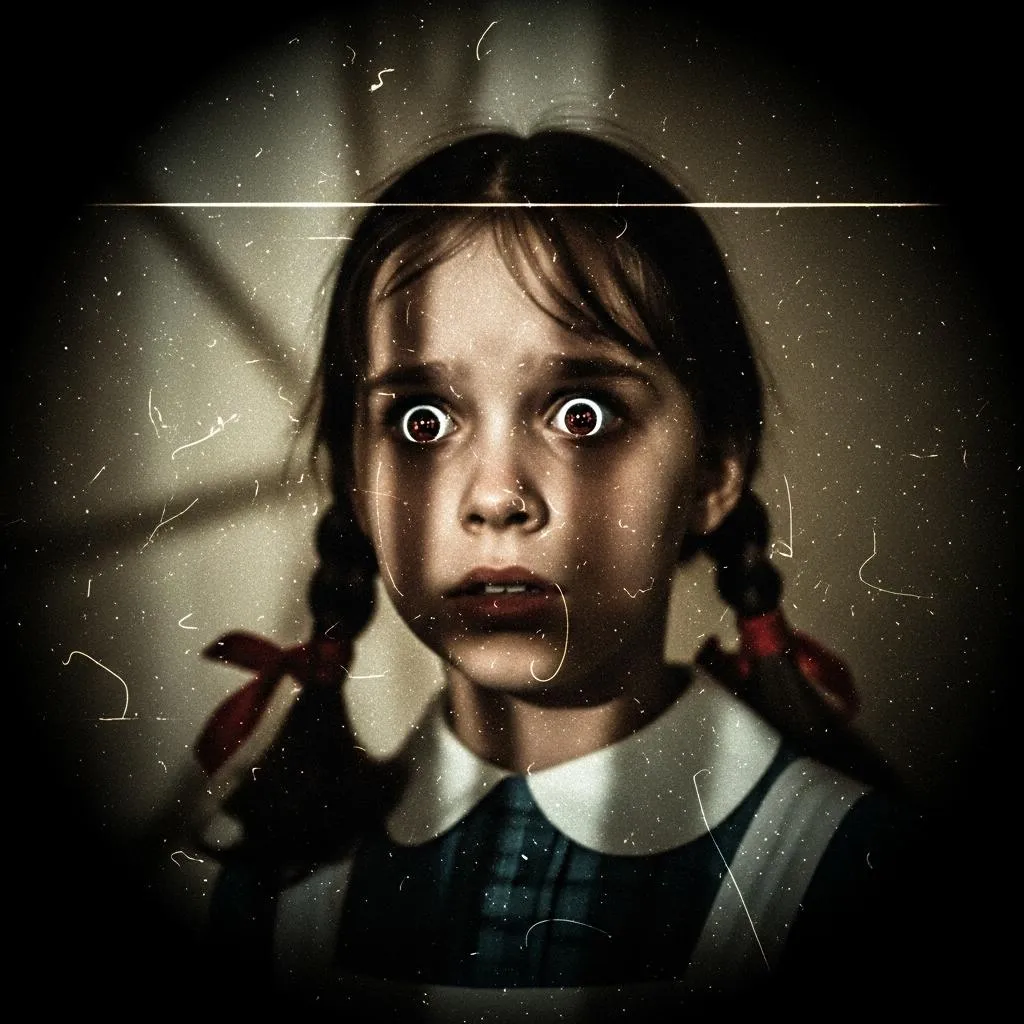
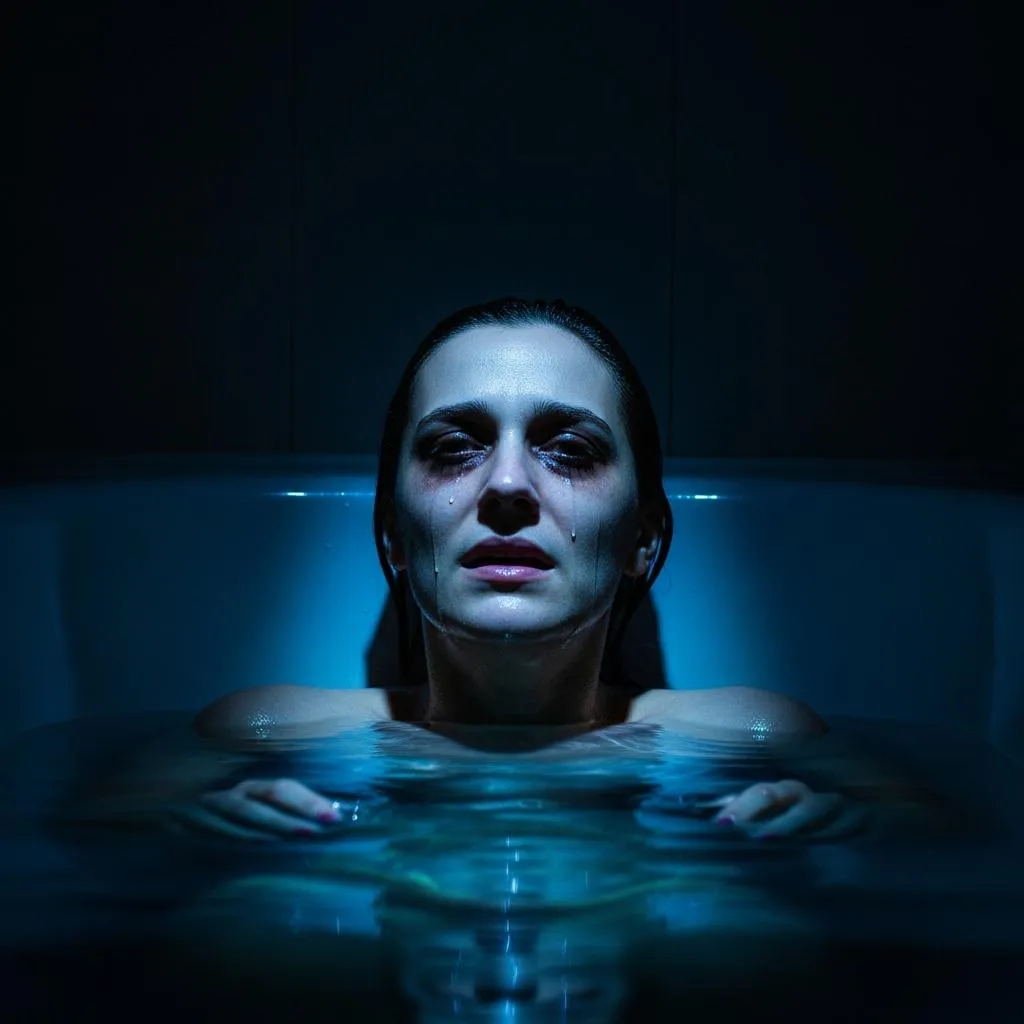
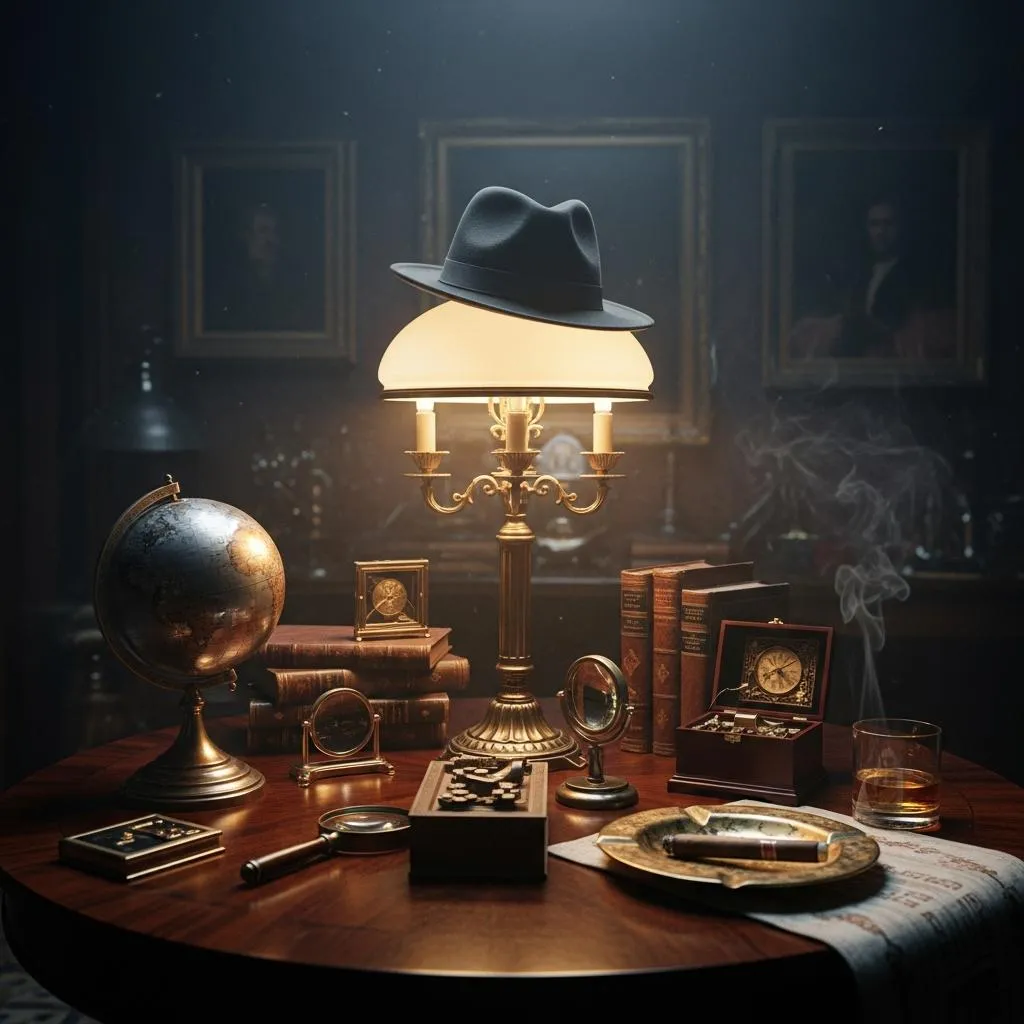
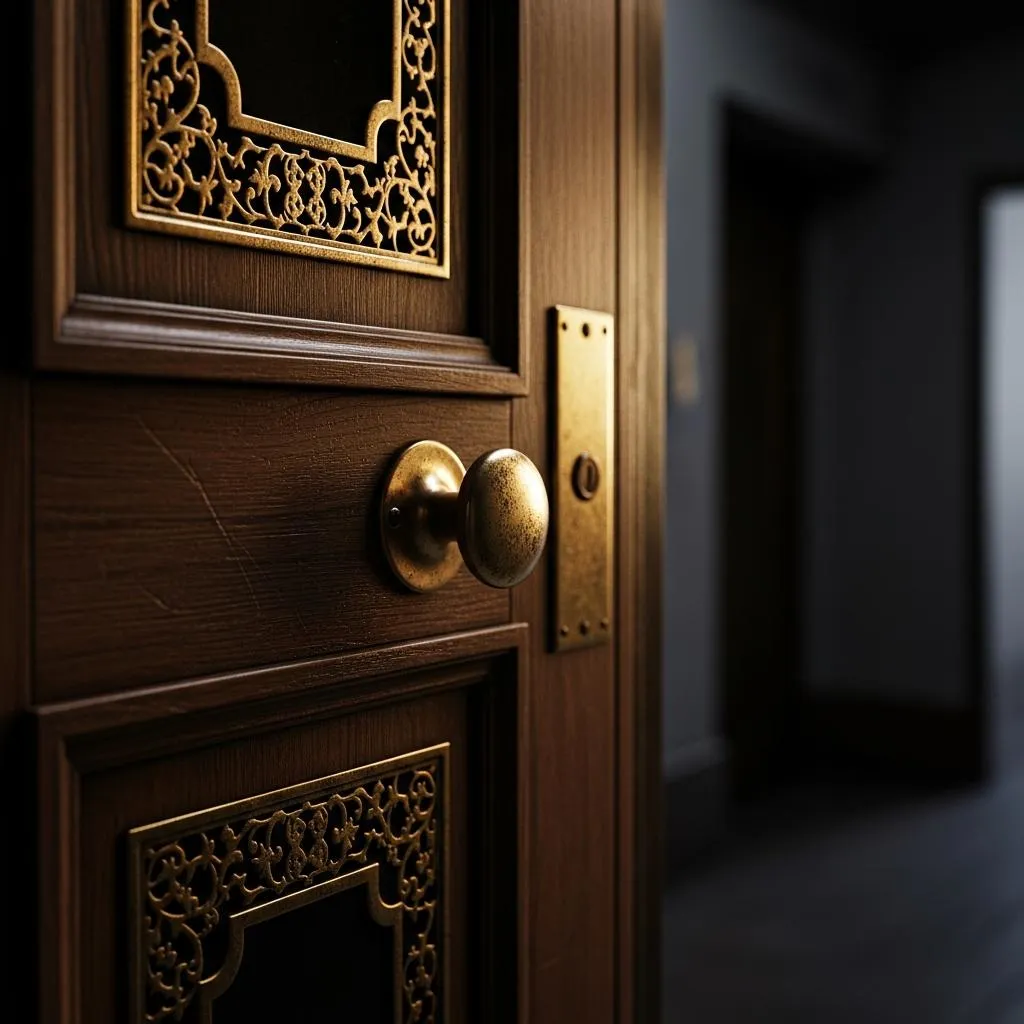
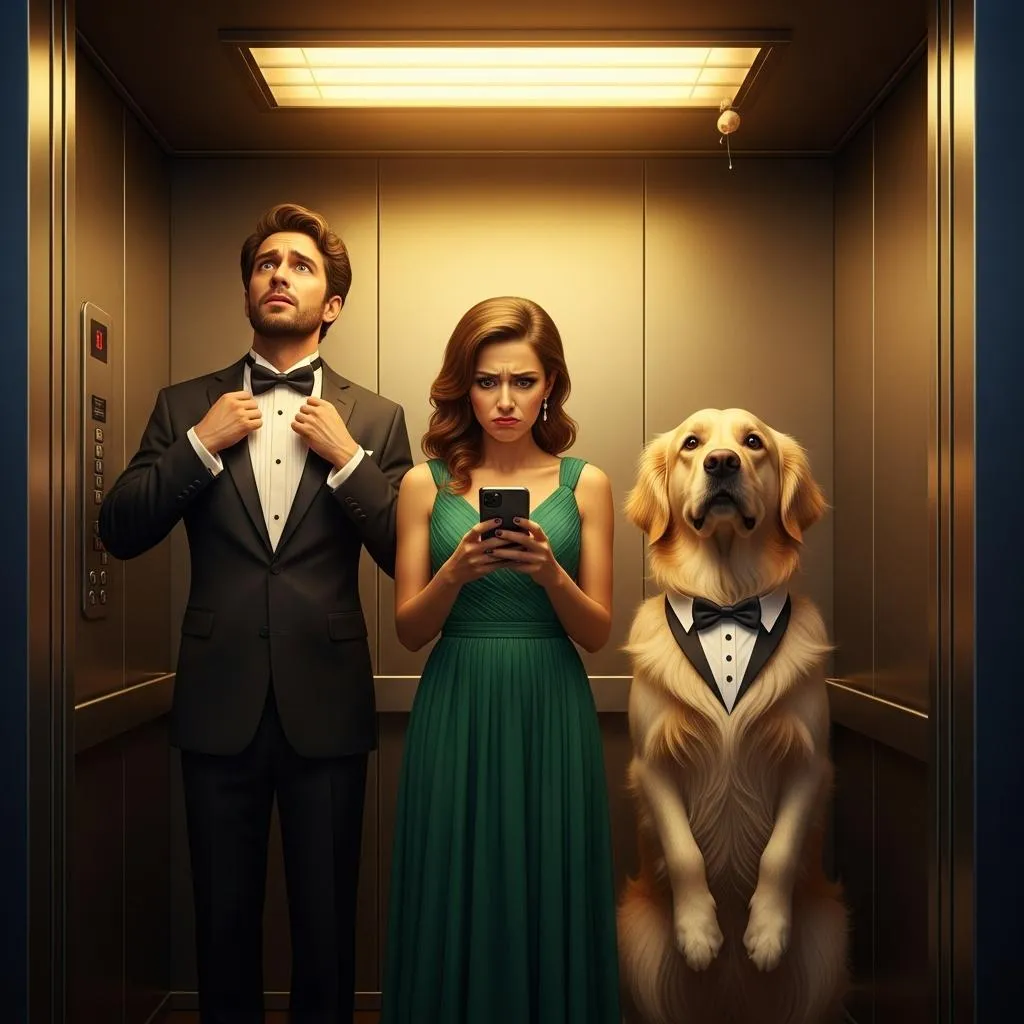
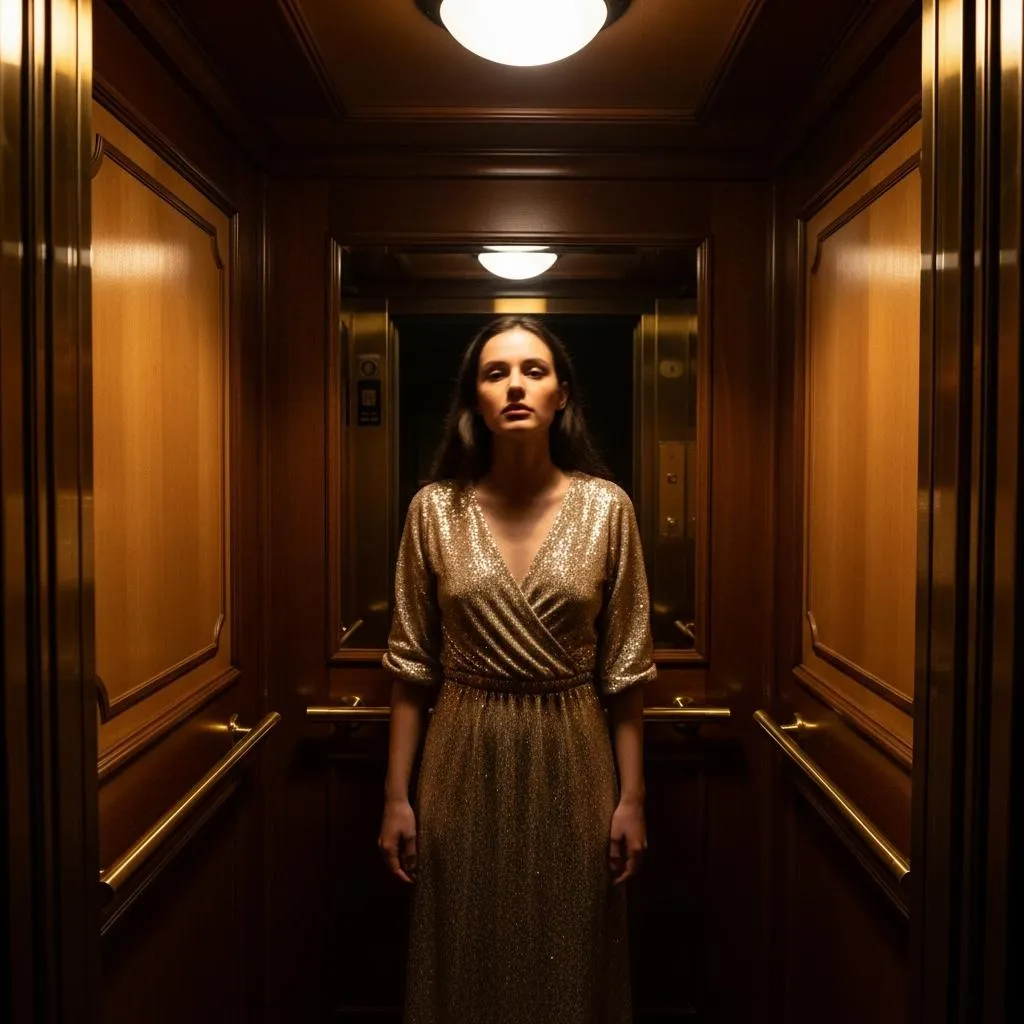
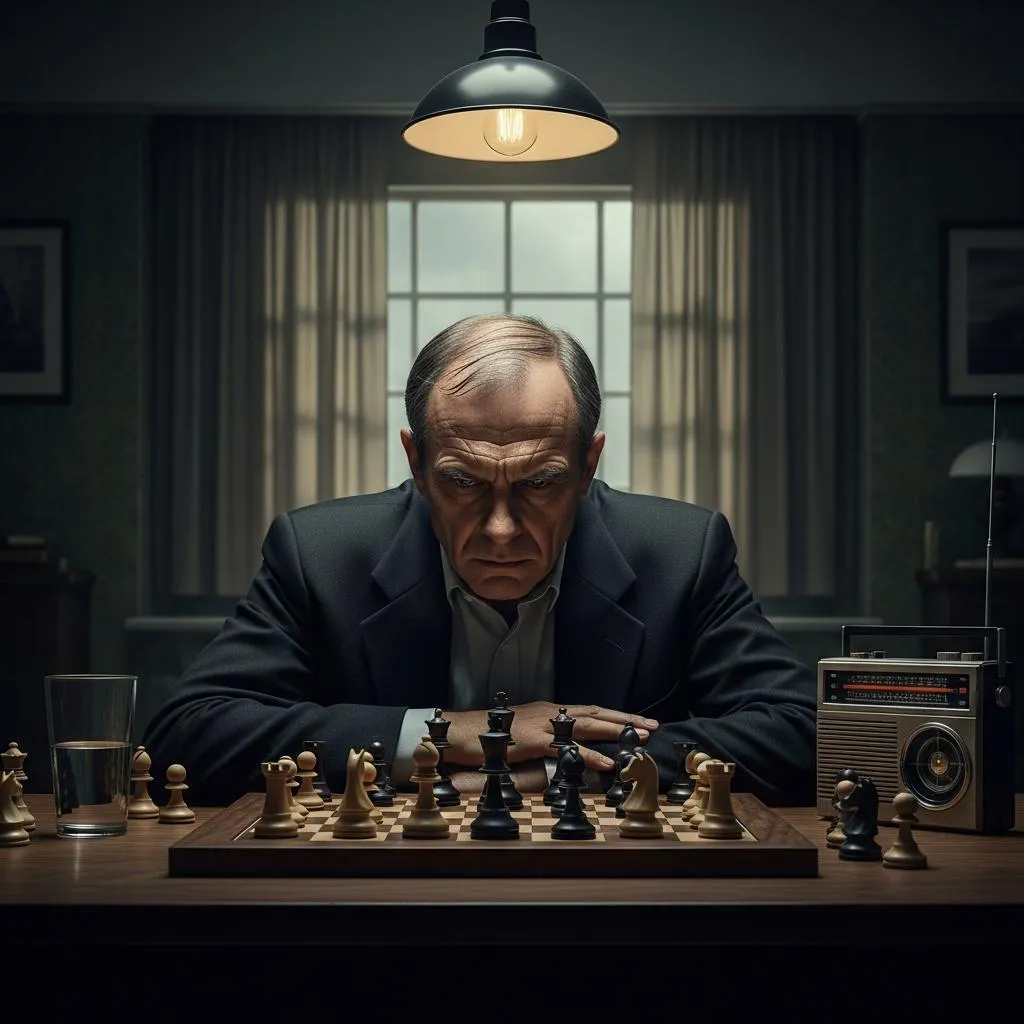
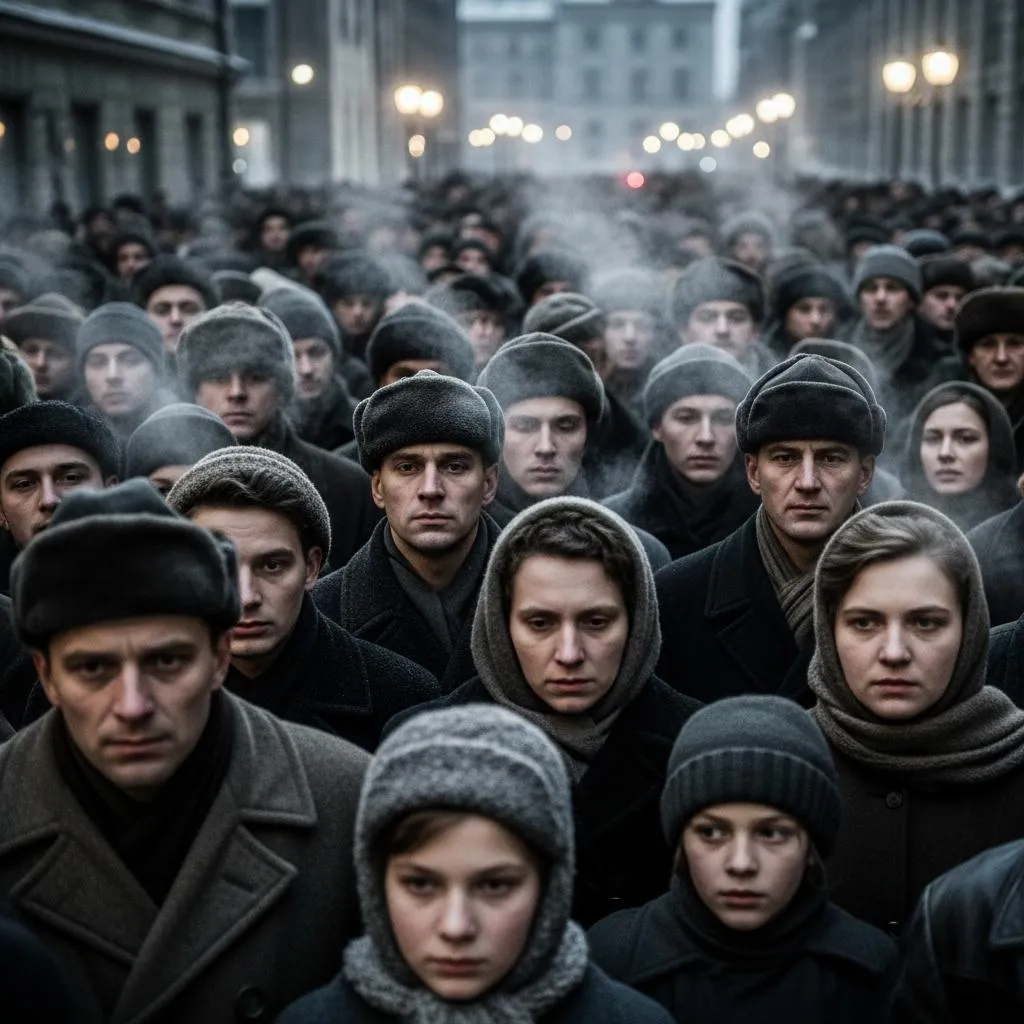
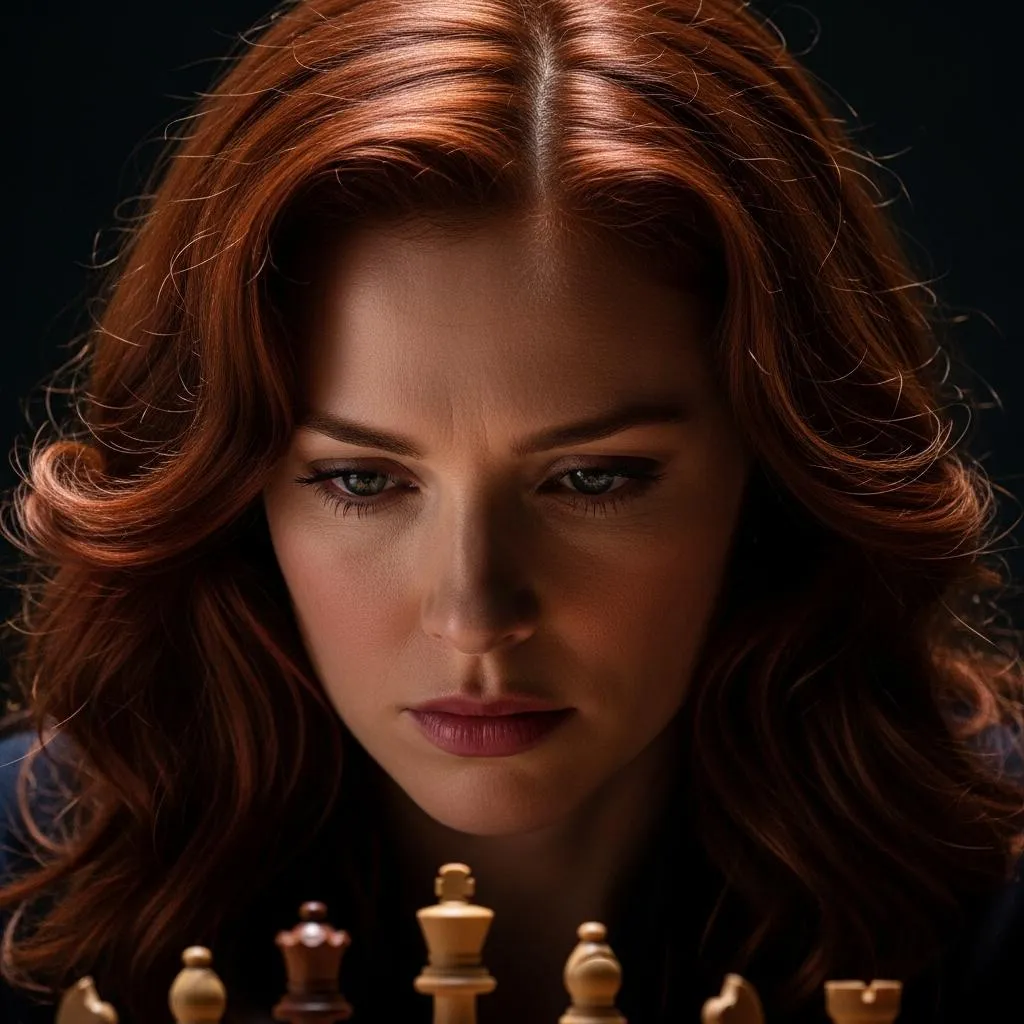
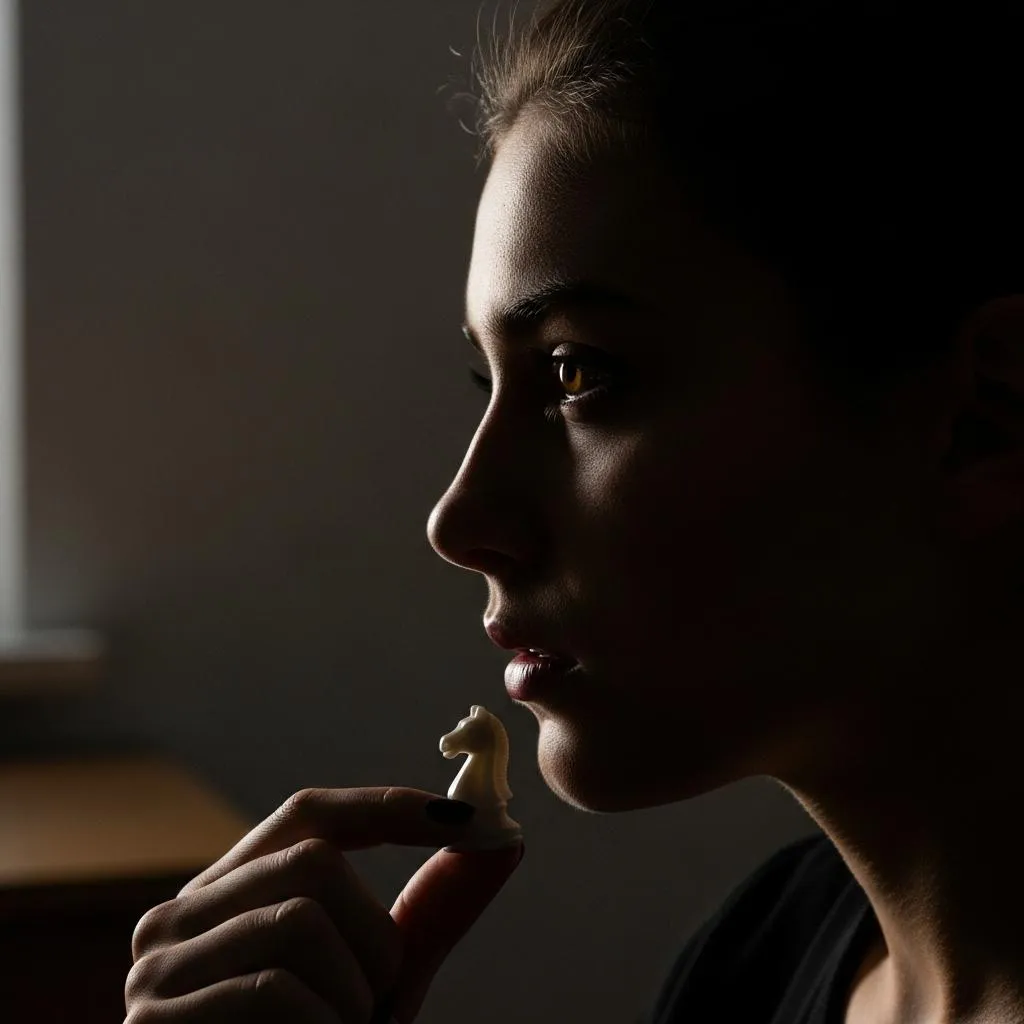
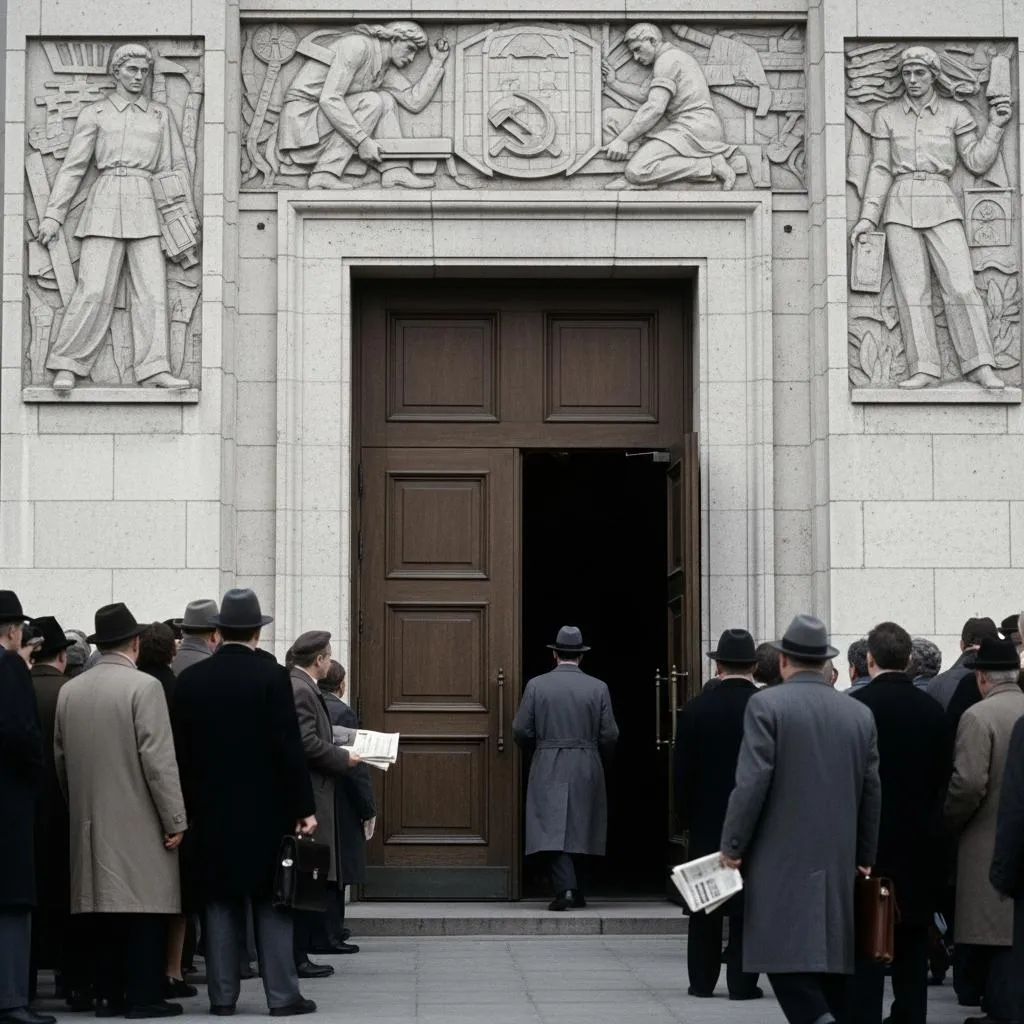
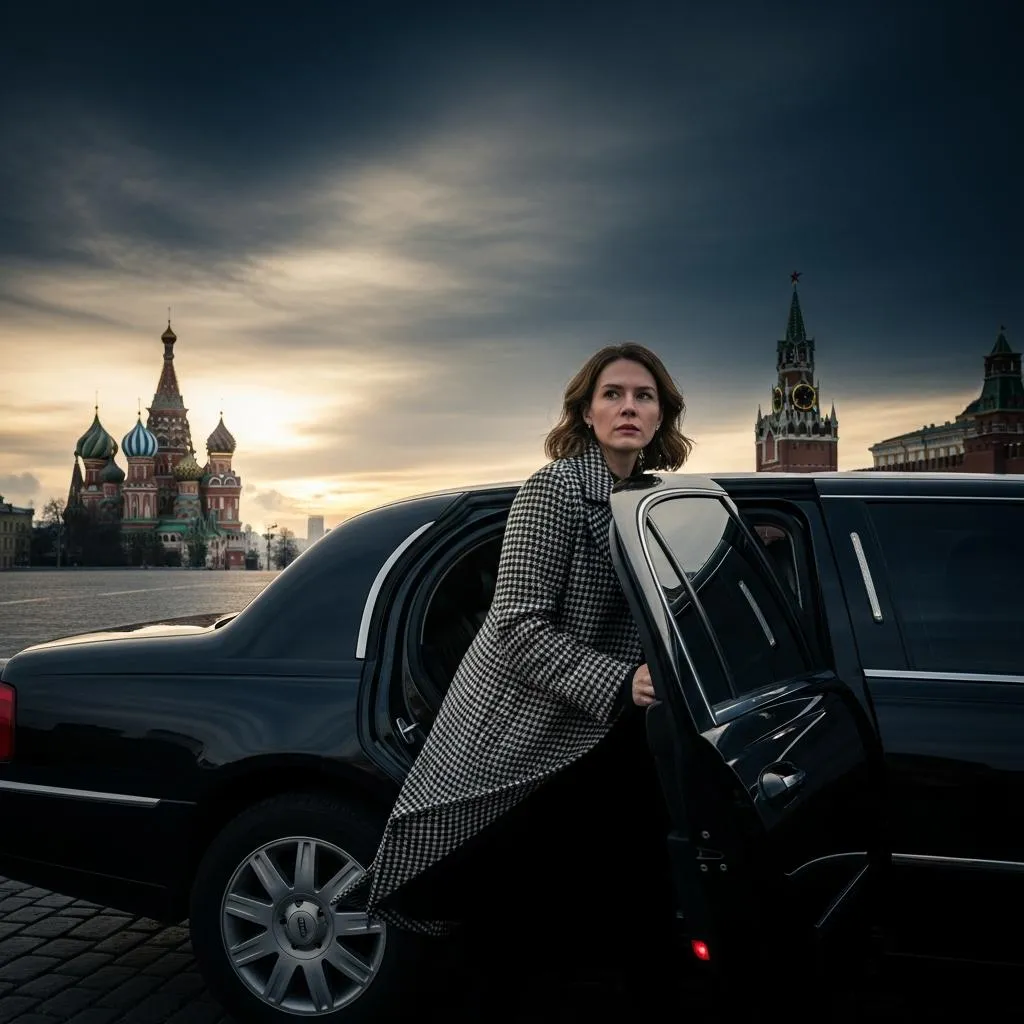
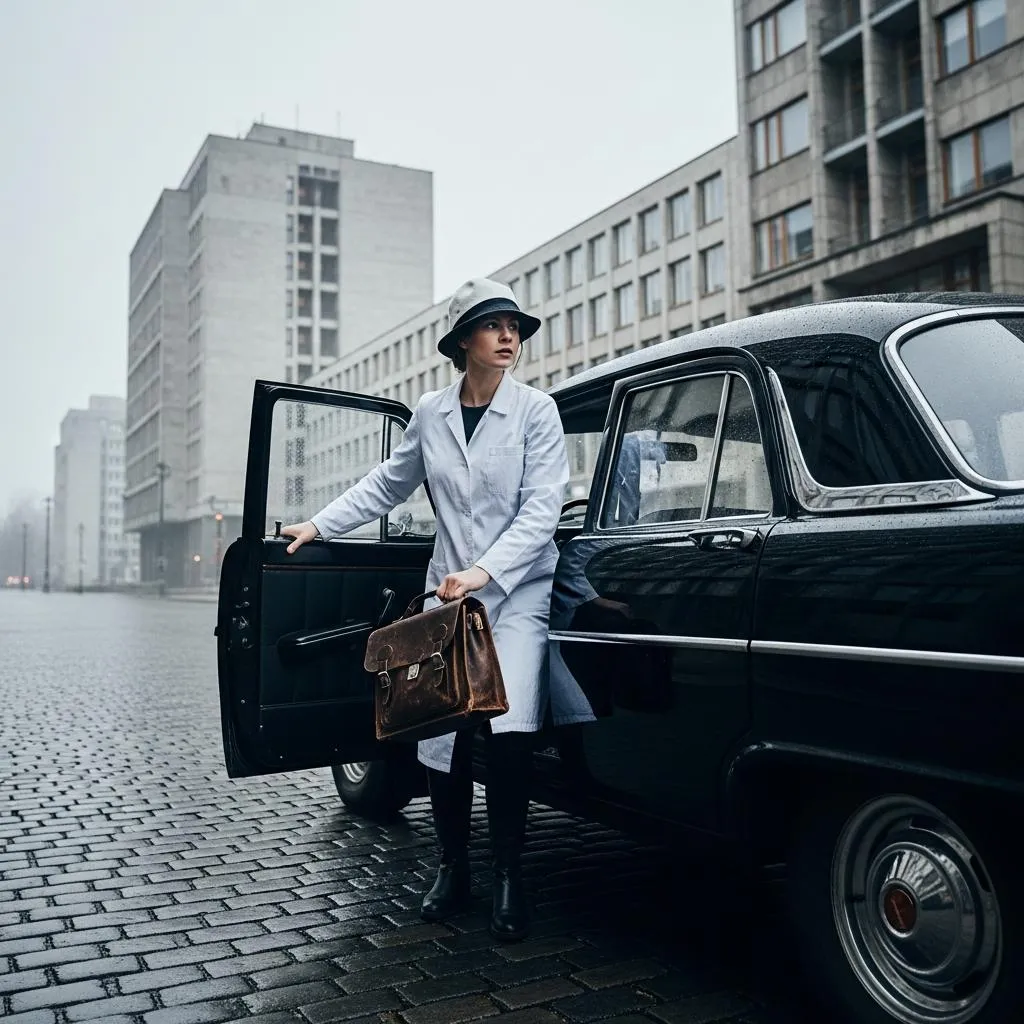
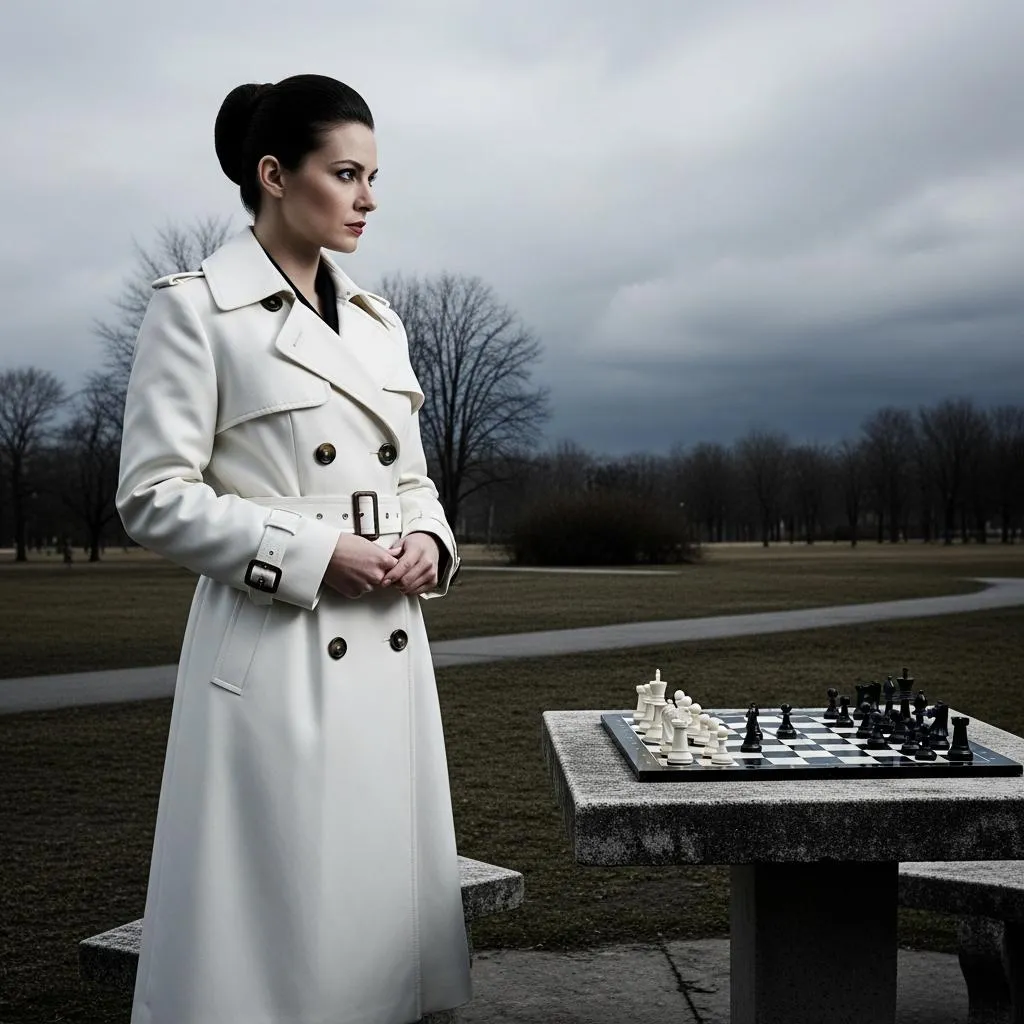
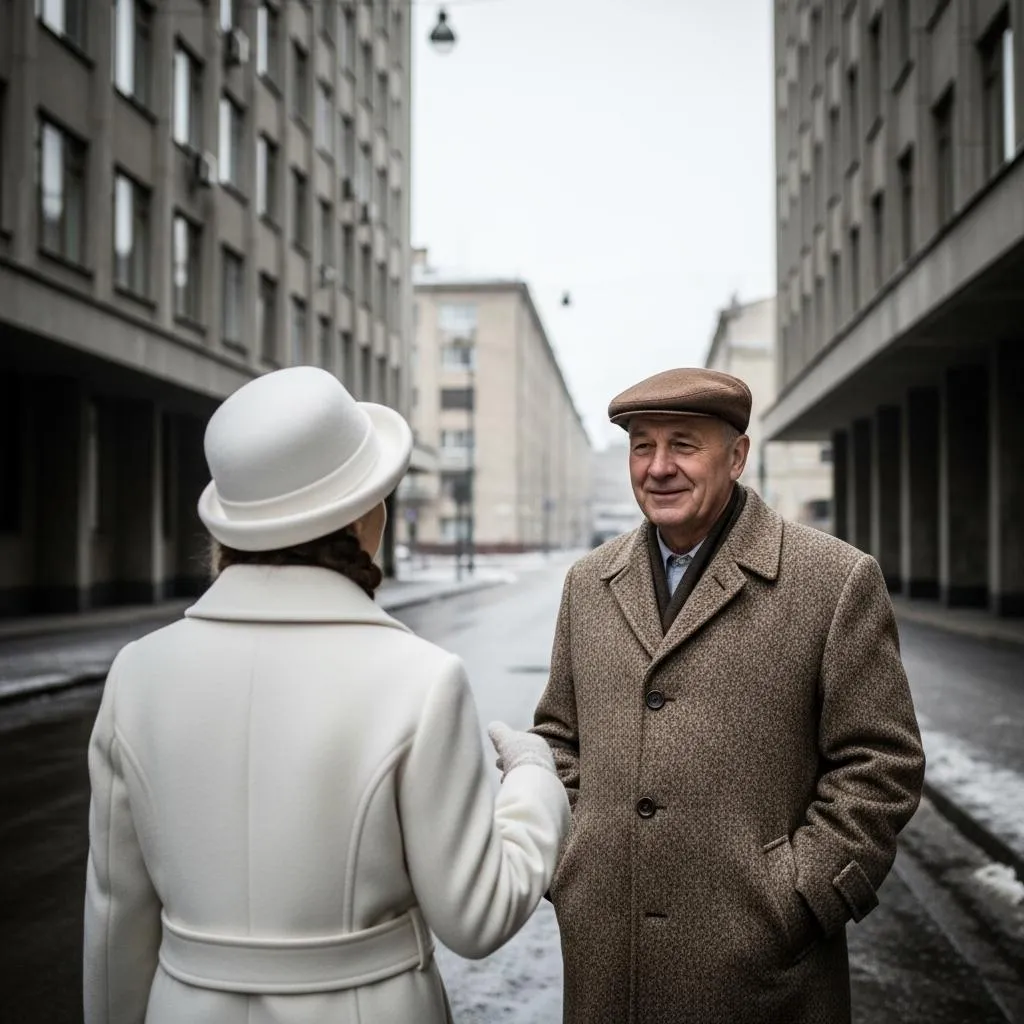
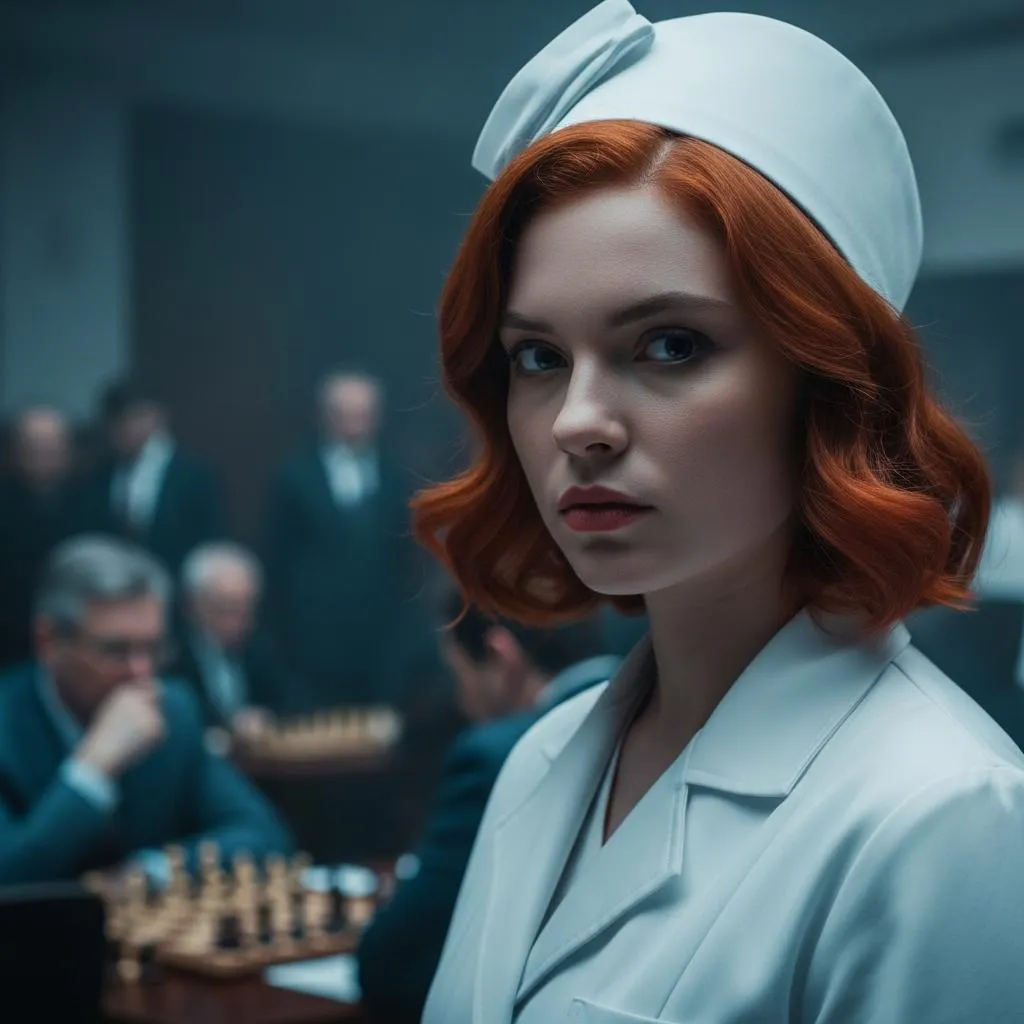

In [32]:
scene_view.select(
    scene_view.pos,
    scene_view.trailer_prompt,
    scene_view.trailer_image
).order_by(scene_view.title, scene_view.pos).collect()

Now that these are stored persistently, you can see the images have a spot in your local file cache. Read more about external files in our docs: https://docs.pixeltable.com/platform/external-files

In [33]:
scene_view.select(
    scene_view.pos,
    scene_view.title,
    scene_view.trailer_image.localpath
).order_by(scene_view.title, scene_view.pos).collect()

pos,title,trailer_image_localpath
0,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/f6/f6dc/9e8b5aefbd5643d292fa9672fff695ad_22_20_f6dc27ecebeb442985fe4bb032f9cddb.jpeg
1,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/17/1786/9e8b5aefbd5643d292fa9672fff695ad_22_20_17867f4cb7e44d11871fbee9ed5a238d.jpeg
2,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/40/40e8/9e8b5aefbd5643d292fa9672fff695ad_22_20_40e87616dfa0430f803e80b4eea1300f.jpeg
3,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/ca/ca1b/9e8b5aefbd5643d292fa9672fff695ad_22_20_ca1bd8b444ce4cafb1f6b1f4cdbda98b.jpeg
4,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/15/152a/9e8b5aefbd5643d292fa9672fff695ad_22_20_152a23da41844102b2237418e0fa65b6.jpeg
5,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/dc/dce1/9e8b5aefbd5643d292fa9672fff695ad_22_20_dce15049413242a1a3522baccc7f02c9.jpeg
6,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/af/af38/9e8b5aefbd5643d292fa9672fff695ad_22_20_af38fd58433046079c823b701a28cb00.jpeg
7,Only Murders in the Building,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/45/4504/9e8b5aefbd5643d292fa9672fff695ad_22_20_450416a8e2634addb6c6e7daf912e0b5.jpeg
0,The Queens Gambit,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/1e/1e4e/9e8b5aefbd5643d292fa9672fff695ad_22_20_1e4e400573e34ae193da198affae6998.jpeg
1,The Queens Gambit,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/b3/b3ad/9e8b5aefbd5643d292fa9672fff695ad_22_20_b3adb020db974bbdaf6a92c1a5b8e10c.jpeg


## Wrap-Up

**Across this three-part workshop, you built a complete multimodal AI pipeline:**

- **Act 1**: Visual search - Extract frames, create embeddings, search by image or text
- **Act 2**: Audio search - Detect scenes, transcribe audio, search by semantic meaning
- **Act 3**: Content generation - Chain AI models to create new images and videos

In Act 3, you built a content generation pipeline that chains AI models together using computed columns:

```
┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  INPUT                EXTRACT              ANALYZE                GENERATE                                  │
│                                                                                                             │
│  ┌──────────────┐   ┌────────────────┐   ┌──────────────────┐   ┌──────────────────────────────────────┐  │
│  │   Scenes     │──▶│     Frame      │──▶│  Multimodal AI   │──▶│          Generation                  │  │
│  │              │   │   Extraction   │   │                  │   │                                      │  │
│  │ Video scenes │   │                │   │ Input:           │   │  ┌────────────┐   ┌──────────────┐  │  │
│  │ with         │   │ Input:         │   │ • image (frame)  │   │  │   Imagen   │──▶│     Veo      │  │  │
│  │ metadata:    │   │ • video        │   │ • text (title)   │   │  │    4.0     │   │     3.1      │  │  │
│  │ • video      │   │                │   │ • text (promo)   │   │  │            │   │              │  │  │
│  │ • title      │   │ Output:        │   │ • text (script)  │   │  │ Input:     │   │ Input:       │  │  │
│  │ • promo      │   │ • image        │   │                  │   │  │ • text     │   │ • image      │  │  │
│  │ • transcript │   │                │   │ Model:           │   │  │   (prompt) │   │ • text       │  │  │
│  │              │   │                │   │ Gemini 2.0 Flash │   │  │            │   │   (prompt)   │  │  │
│  │              │   │                │   │                  │   │  │ Output:    │   │              │  │  │
│  │              │   │                │   │ Output:          │   │  │ • image    │   │ Output:      │  │  │
│  │              │   │                │   │ • text (prompt)  │   │  └────────────┘   │ • video      │  │  │
│  │              │   │                │   │                  │   │                   └──────────────┘  │  │
│  └──────────────┘   └────────────────┘   └──────────────────┘   └──────────────────────────────────────┘  │
└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added content generation to your video pipeline. Act 1 gave you visual similarity search (find frames by what they look like). Act 2 gave you semantic audio search (find scenes by what's being said). Act 3 gives you generative AI (create new promotional content from any scene).

Together, these three capabilities form a complete multimodal system. The embeddings from Act 1 power visual search. The scene detection and transcription from Act 2 structure the video data and make it searchable by audio. Act 3 chains multiple AI models—Gemini analyzes frames and transcripts to write prompts, Imagen generates images from those prompts, and Veo can animate them into video clips.

**Each step is declarative:**
- **Input**: Scene data from `scene_view` (built in Act 2)
- **Extract**: Frame extraction via computed column processes all scenes
- **Generate**: AI models chain together via computed columns—Gemini's output becomes Imagen's input
- **Cascade**: When you add new videos to `primetime_vids`, the scene detection, transcription, and generation pipeline processes them

The workflow applies to all data. If you load another video tomorrow, the same pipeline that processed your first video will process the new one.